In [1]:
from ipynb.fs.full.useful_functions_for_QAOAAnsatz import *

In [2]:
def plot_histogram_of_best_column(df, best_column, EXACT_COVERS, title=''):
    ax = plot_histogram_of_df_column(df, best_column, EXACT_COVERS, title=title)
    df = df.set_index('states')
    df = df.astype(float).fillna(0.0)

    ##### COMPUTE PERCENTAGES AND ADD AVERAGE COLUMN
    total = df.sum()
    percentage = (df/ total) * 100
    
    percentage['average'] = percentage.mean(numeric_only=True, axis=1)
    percentage['std'] = percentage[percentage.columns[:-1]].std(numeric_only=True, axis=1)
        
    ##### KEEP THE BEST AND THE AVERAGE RESULT
    percentage = percentage[[best_column, "average", "std"]]
    percentage = percentage.sort_values(best_column, ascending=False)
    
            
    ### Display errors, but just for the "average" bars.
    x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches] 
    y_coords = percentage["average"]
    ax.errorbar(x=x_coords, y=y_coords, yerr=percentage["std"], linestyle="",
                markerfacecolor='none', linewidth=1,
                marker='o', color='k', ecolor='k', elinewidth=0.7, capsize=3.5, 
                barsabove=True, alpha=0.5) # label=f"Average on {random_attempts} random attempts"

    plt.show()

In [3]:
def plot_histogram_of_df_column(df, column_to_plot, EXACT_COVERS, title=''):
    df = df.set_index('states')
    df = df.astype(float).fillna(0.0)
    
    # ##### COMPUTE PERCENTAGES AND ADD AVERAGE COLUMN
    total = df.sum()
    percentage = (df/ total) * 100

    percentage = percentage[[column_to_plot]]
    percentage = percentage.sort_values(column_to_plot, ascending=False)
    
    ##### FIGURE
    plt.figure(figsize=(7,5))
    N = 10
    ax = sns.barplot(x="states", y=column_to_plot, data=percentage, 
                     width=0.7, color='red', alpha=0.5) #label=f"Lowest energy among {random_attempts} random attempts"
    
    ### Make labels with percentages.
    labels = percentage[column_to_plot].round(1).astype('str') + '%'
    for container in ax.containers:
            ax.bar_label(container, labels=labels, fontsize=N-2)
            
    ### Highlight exact covers' ticks with red.
    df_for_ticks = percentage.copy()
    df_for_ticks["states"] = df_for_ticks.index
    highlight_correct_ticks(ax, EXACT_COVERS)
    
    ### Refinements.
    plt.xlabel("states", fontsize=N)
    plt.ylabel("", fontsize=N)
    plt.xticks(fontsize=N-2, rotation="vertical")
    plt.yticks(fontsize=N)
    plt.xlim(xmin=-1)
    plt.ylim(ymin=0, ymax=106)
    plt.minorticks_on()
    plt.grid(alpha=0.2)
    plt.title(title, fontsize=N)

    return ax        

In [6]:
def find_parameter_fixing_files(strings, path=None, verbose=False):    
    # """
    # Find .txt and .csv files containing all the strings in strings,
    # ordered by number of instance.
    
    # Parameters
    # ----------
    #     path (str): path of the file. The default is './'.
    #     strings (list): list of strings that the files must contain.
    #     verbose (bool): if True, print is activated.

    # Return
    # ------
    #     DATA_FILENAME_list (list of str): a list containing the .txt files.
    #     FILENAME_list (list of str): a list containing the .csv files.
    # """
    if path == None: path = './'
    
    FILENAME_list = []
    DATA_FILENAME_list = []
    for obj in os.listdir(path):
        if os.path.isfile(os.path.join(path,obj)) and not("random" in obj):
            if '_data.txt' in obj:
                DATA_FILENAME_list.append(path+obj)
                if verbose: print(path+obj)
            elif '.csv' in obj:
                FILENAME_list.append(path+obj)
                if verbose: print(path+obj)

    ### RIORDINO IN BASE AL NUMERO DELL'ISTANZA
    find_number_of_instance = lambda x: int((x.split('_mail')[1]).split('_all')[0])
    FILENAME_list = sorted(FILENAME_list, key=find_number_of_instance)
    DATA_FILENAME_list = sorted(DATA_FILENAME_list, key=find_number_of_instance)

    
    return FILENAME_list, DATA_FILENAME_list

In [8]:
def plot_list_of_files(FILENAME_list, DATA_FILENAME_list, title=''):
    
    fig = plt.figure(figsize=(20,7))
    fig.suptitle(title)
    
    N = 11 # fontsize

    num_cols = 2
    num_rows = math.ceil(len(FILENAME_list)/2)
    for num_subplot, (FILENAME, DATA_FILENAME) in enumerate(zip(FILENAME_list, DATA_FILENAME_list)):
        
        ##### EXTRAPOLATE INFORMATION FROM THE FILENAME
        n, instance, init_name, p, random_attempts, k = define_parameters_from_filename(DATA_FILENAME, verbose=True)
        
        ##### WITH THIS INFORMATION, GET THE INSTANCE SETS
        U, subsets_dict = define_instance(n, instance, verbose=False)
        
        ##### FIND FEASIBLE STATES, ENERGIES, EXACT COVERS
        states, energies, states_feasible, energies_feasible, EXACT_COVERS = find_spectrum(U, subsets_dict, n, k)
        # print("\nEXACT_COVERS: ", EXACT_COVERS)
        
        ###########################################################
        ###########################################################
        
        ##### UPLOAD THE DATAFRAME FROM FILE
        df = pd.read_csv(FILENAME, dtype = str).set_index('states')
        df = df.astype(float).fillna(0.0)
        
        
        ##### COMPUTE PERCENTAGES AND ADD AVERAGE COLUMN
        total = df.sum()
        percentage = (df/ total) * 100
        
        percentage['average'] = percentage.mean(numeric_only=True, axis=1)
        percentage['std'] = percentage[percentage.columns[:-1]].std(numeric_only=True, axis=1)
        
        ##### FIND THE BEST HISTOGRAM INDEX (i_best) BASED ON THE MINIMUM ENERGY FOUND
        with open(DATA_FILENAME, 'r') as DATA_FILE:
            for line in DATA_FILE:
                if 'Attempt that reached the best result with' in line:                
                    string = line.split('#')[1]
                    i_best = string.split(' ')[0]
                    # print("string", string)
                    # print("i_best is", i_best)
                    
        ##### THE COLUMN CORRESPONDING TO THE BEST RESULT
        column_best = f'counts_p{p}_{i_best}of{random_attempts}'
        
        
        ##### KEEP THE BEST AND THE AVERAGE RESULT
        percentage = percentage[[column_best, "average", "std"]]
        percentage = percentage.sort_values(column_best, ascending=False)
        
        
        ##### FIGURE
        fig.add_subplot(num_rows, num_cols, num_subplot+1)
        ax = sns.barplot(x="states", y=column_best, data=percentage, width=0.7, color='red', alpha=0.5) #label=f"Lowest energy among {random_attempts} random attempts"
        
        ### Make labels with percentages.
        labels = percentage[column_best].round(1).astype('str') + '%'
        for container in ax.containers:
                ax.bar_label(container, labels=labels, fontsize=N-2)
                
        ### Display errors, but just for the "average" bars.
        x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches] 
        y_coords = percentage["average"]
        ax.errorbar(x=x_coords, y=y_coords, yerr=percentage["std"], linestyle="",
                    markerfacecolor='none', linewidth=1,
                    marker='o', color='k', ecolor='k', elinewidth=0.7, capsize=3.5, 
                    barsabove=True, alpha=0.5) # label=f"Average on {random_attempts} random attempts"
        
        ### Highlight exact covers' ticks with red.
        df_for_ticks = percentage.copy()
        df_for_ticks["states"] = df_for_ticks.index
        highlight_correct_ticks(ax, EXACT_COVERS)
        

        ### Set title.
        # path = FILENAME.split('/')[0] +'/'
        # titlestring = FILENAME.replace(path, '')
        # if title in titlestring: 
        #     titlestring = titlestring.replace(title, '')
            
        # subtitlestring = '\nBOUNDS' + titlestring.split('BOUNDS')[1]
        # titlestring = titlestring.split('BOUNDS')[0] + subtitlestring
        # ax.set_title(titlestring, fontsize=N-3)
        s = "n={0}, i={1}, {2}, p={3}, ra={4}, k={5}".format(n, instance, init_name, p, random_attempts, k)
        if title in s: s = s.replace(title, '')
        s = s + '\nBOUNDS' + FILENAME.split('BOUNDS')[1]
        ax.set_title(s, fontsize=N)
        
        ### Refinements.
        plt.xlabel("states", fontsize=N)
        plt.ylabel("", fontsize=N)
        plt.xticks(fontsize=N-2, rotation="vertical")
        plt.yticks(fontsize=N)
        plt.xlim(xmin=-1)
        plt.ylim(ymin=0, ymax=106)
        plt.minorticks_on()
        plt.grid(alpha=0.2)
        # ax.set_title(f"instance {instance}, k = {k}", fontsize=N)
        
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
    plt.show()

In [10]:
def plot_list_of_files_parameter_fixing(FILENAME_list, DATA_FILENAME_list, title=''):
    fig = plt.figure(figsize=(30,10))
    num_rows = 2
    num_cols = math.ceil(len(DATA_FILENAME_list)/2)
    for num_d, d in enumerate(DATA_FILENAME_list):
        
        header = d.replace("_data.txt", "")
        
        n, instance, init_name, maxp, random_attempts, k = define_parameters_from_filename(d, verbose=True)
        title = "n={}, i={}, init={}, maxp={}, ra={}, k={}".format(n, instance, init_name, maxp, random_attempts, k)
        
        ##### WITH THIS INFORMATION, GET THE INSTANCE SETS
        U, subsets_dict = define_instance(n, instance, verbose=False)
        
        ##### FIND FEASIBLE STATES, ENERGIES, EXACT COVERS
        states, energies, states_feasible, energies_feasible, EXACT_COVERS = find_spectrum(U, subsets_dict, n, k)
        # print("\nEXACT_COVERS: ", EXACT_COVERS)
        
        for p in range(1,maxp+1):
            file_to_read = header + f"_p{p}.csv"
 
            df = pd.read_csv(file_to_read, dtype = {'states':"str", f'counts_p{p}':"Int64"})
    
            # Merge dataframes.
            if p == 1:
                df_final = df
            else:
                df_final = pd.merge(df_final, df, on="states", how="outer")    

        
        df_final = df_final.fillna(0)
        ax = fig.add_subplot(num_rows, num_cols, num_d+1)
        ax.set_title(title)
        # ax = sns.barplot(x="states", y=f'counts_p{p}', data=df_final, width=0.7, color='red', alpha=0.5) #label=f"Lowest energy among {random_attempts} random attempts"
        
        df_final.plot(x='states', kind="bar", fontsize=8, stacked=False, ax=ax)
            
            
        # Make labels with percentages.
        ax.set_ylabel("counts")
        for i,container in enumerate(ax.containers):
            p = i+1
            labels = df_final[f'counts_p{p}'].apply(lambda x: (x/df_final[f'counts_p{p}'].sum())*100).round(1).astype('str') + '%'
            ax.bar_label(container, labels=labels)
        highlight_correct_ticks(plt.gca(), EXACT_COVERS)
        ax.set_ylim(0,1024)

        if num_d != 0 and num_d != num_cols:
            ax.get_yaxis().set_visible(False)
        
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.4)
    plt.show()
    

## Do minimization

In [4]:
n = 6 # instance dimension
instances = [3,4,5,6]
init_name = "all1" # type of initialization

h_MEC = [0.167, 0.167, 0.167, 0.112, 0.167, 0.167, 0.251, 0.167, 0.084, 0.084]
h_vector = h_MEC

random_attempts = 10
max_p = 3

kMEC_06-10_dim6_mail3_all1_p3_10ra_k0.167_BOUNDS[0,2pi]x[-220,220]_pars0[0,2pi]x[-220,220]

 **** p = 1 **** 


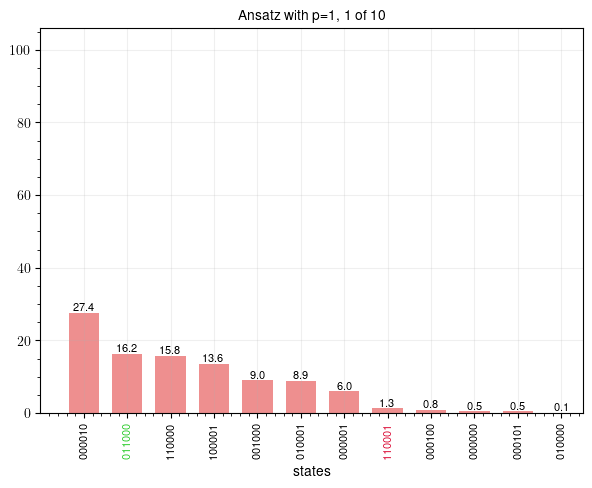

...UPDATING...


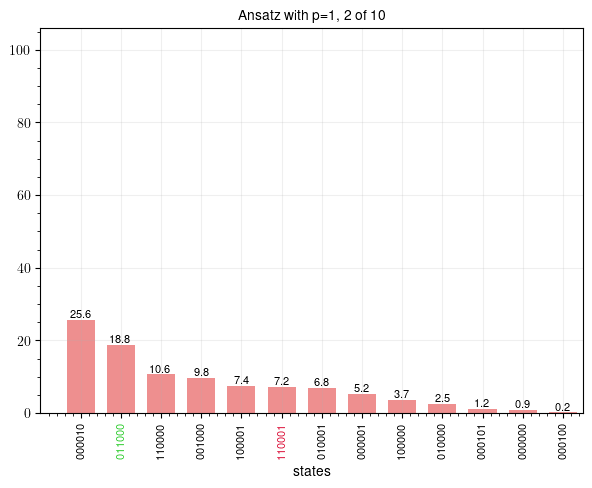

...UPDATING...


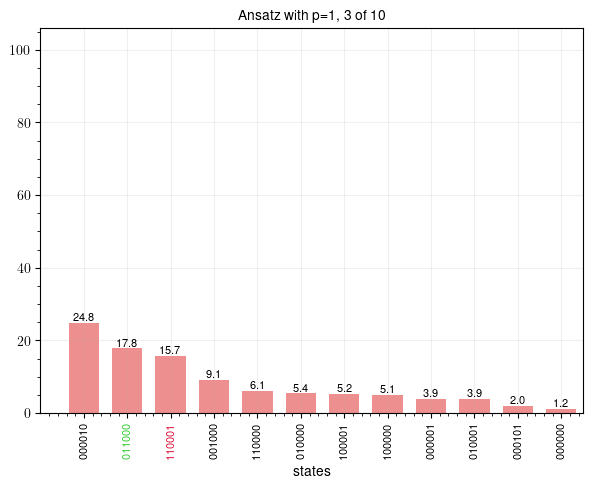

...UPDATING...


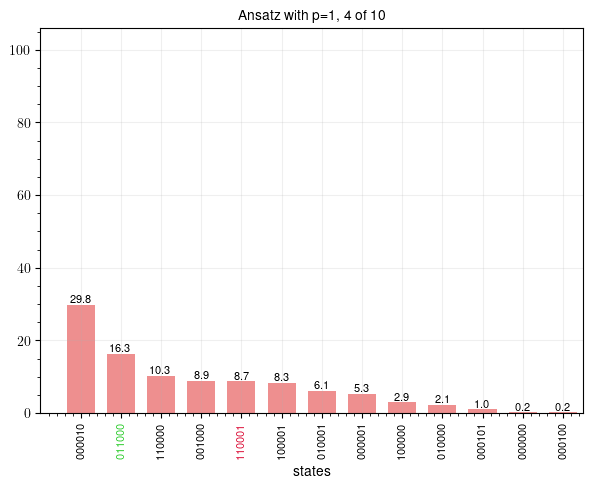

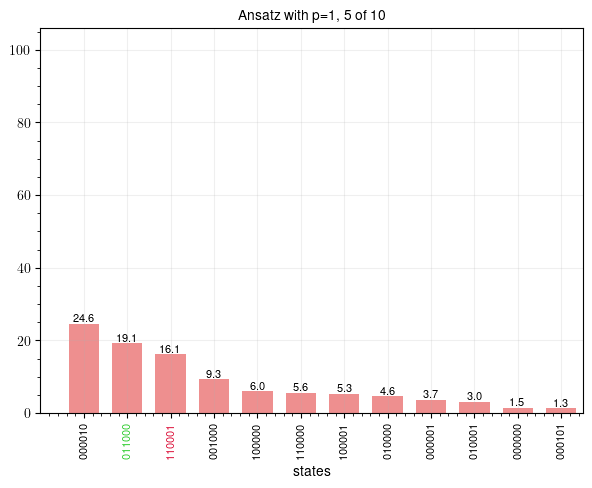

...UPDATING...


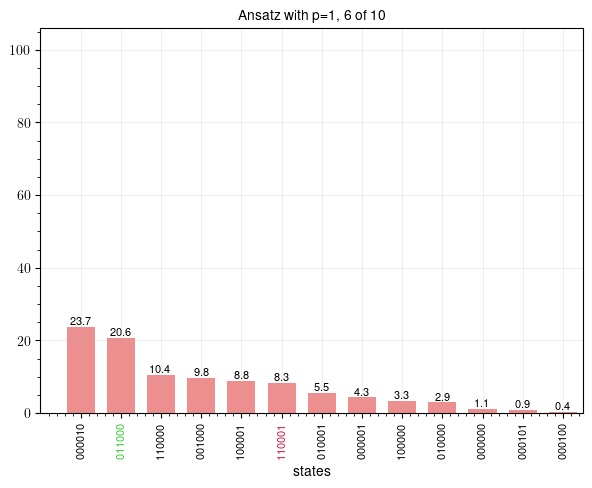

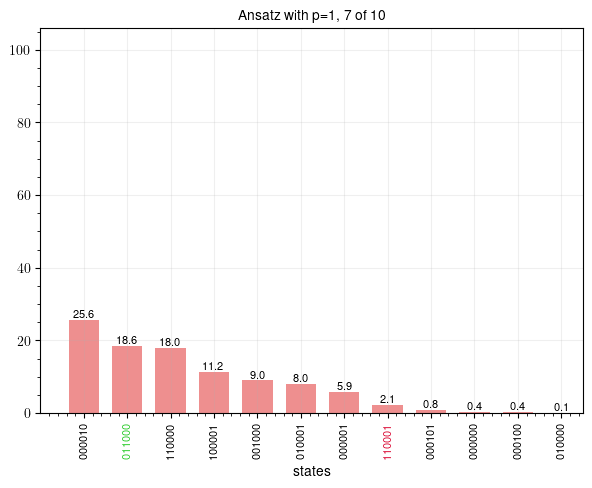

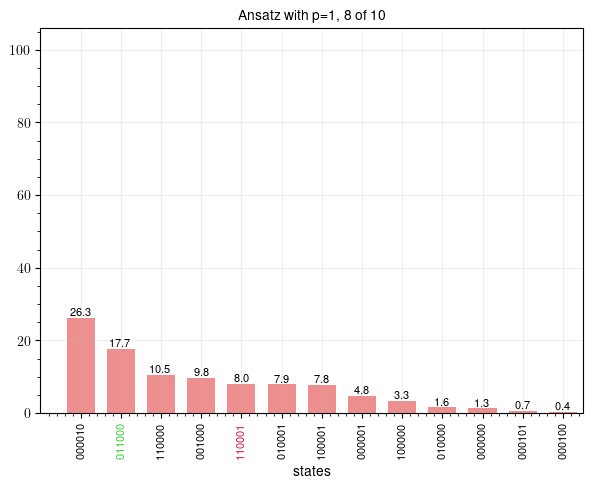

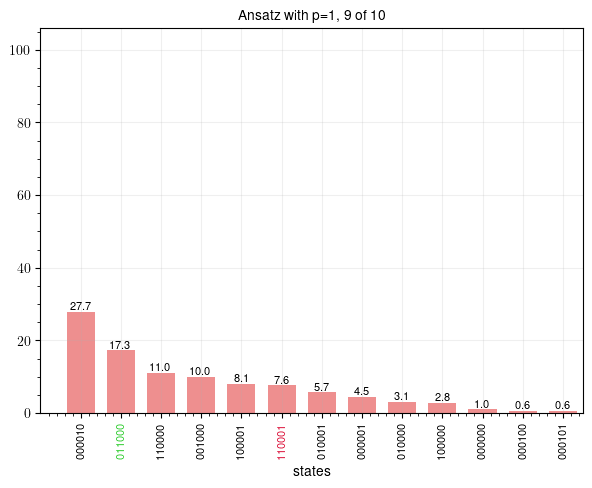

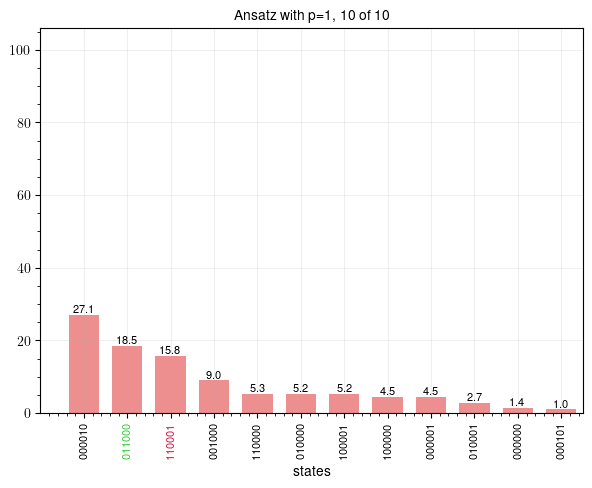

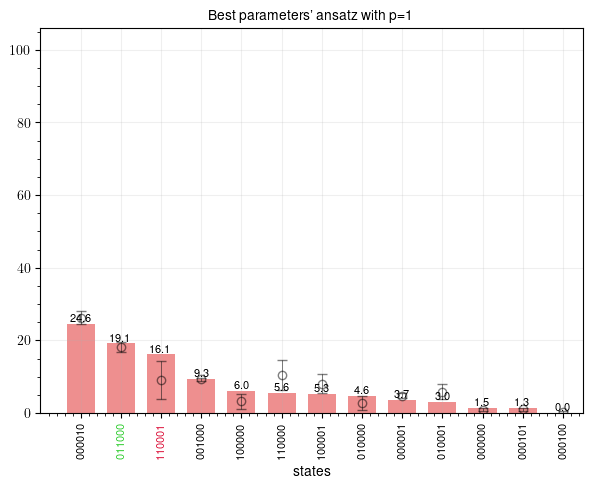


BEST PARAMETERS OFù p=1 LAYER: betas, gammas =  [3.8905998672828783] [-4.12417895423651e-07]
Execution time of p=1 layer: 0.7 min

 **** p = 2 **** 


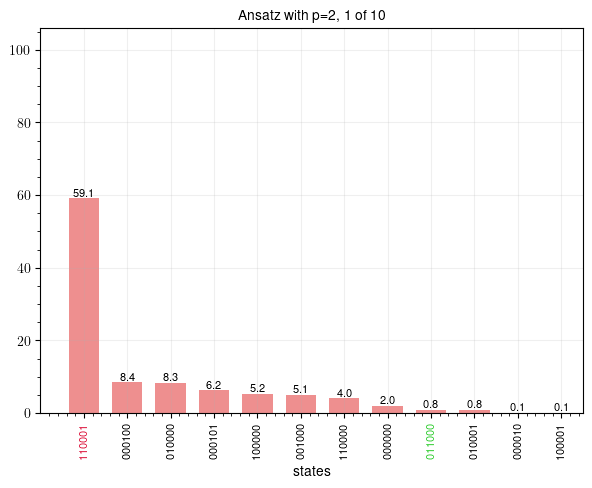

...UPDATING...


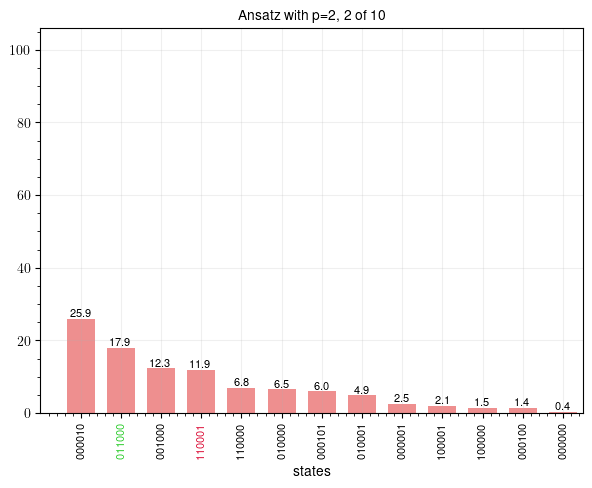

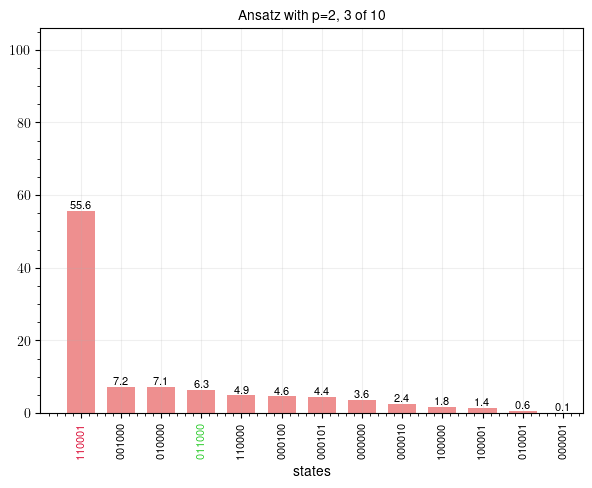

...UPDATING...


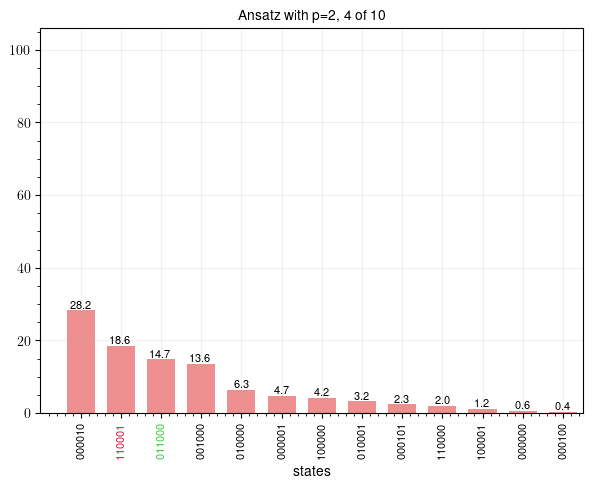

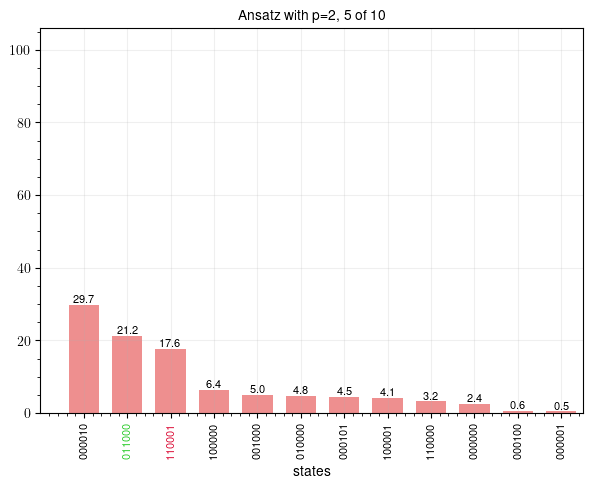

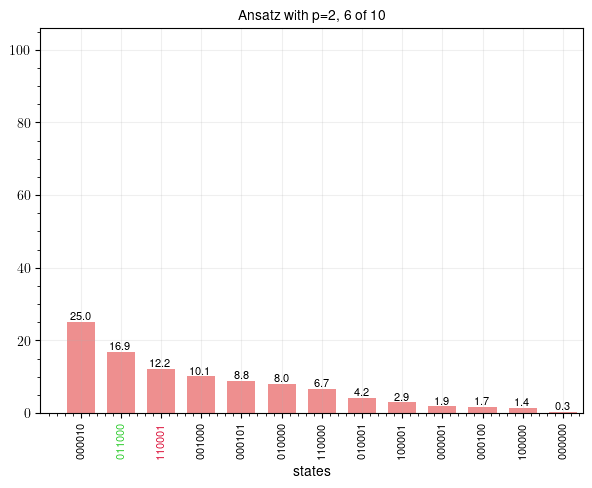

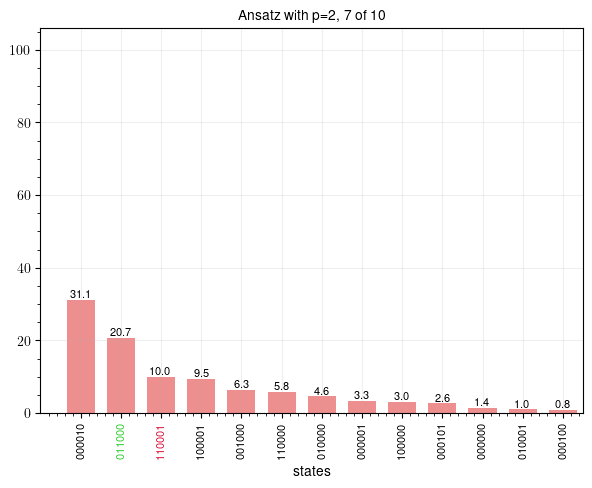

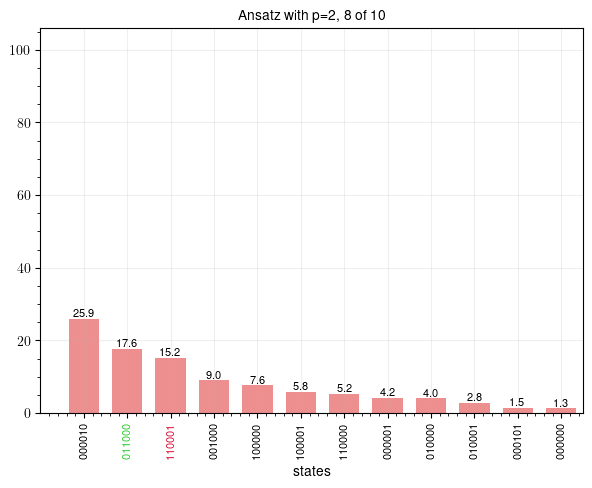

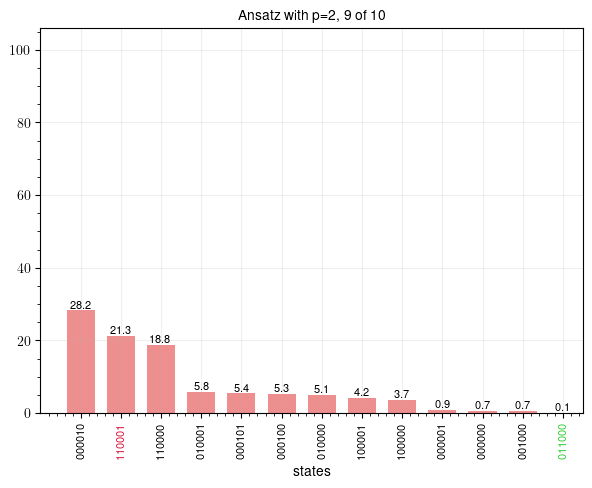

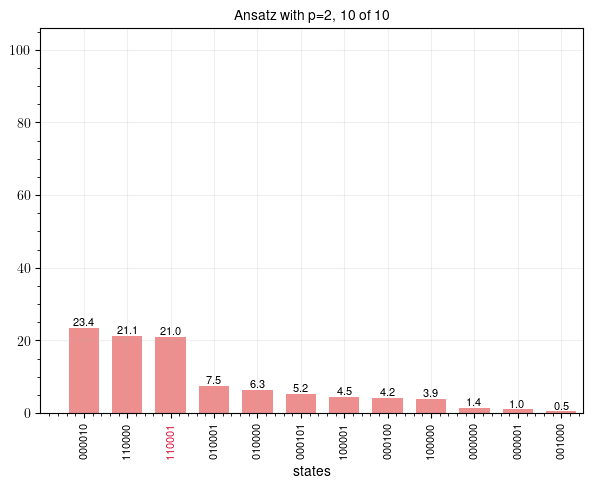

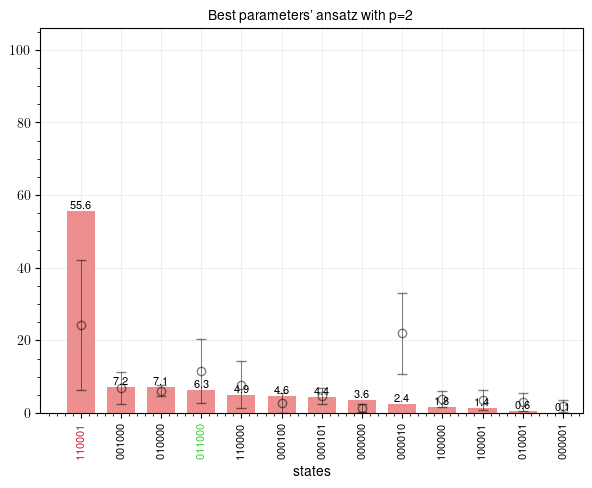


BEST PARAMETERS OFù p=2 LAYER: betas, gammas =  [1.363716624295158, 2.3878261051713277] [-7.728852489485915e-07, 74.57706173924646]
Execution time of p=2 layer: 1.9 min

 **** p = 3 **** 


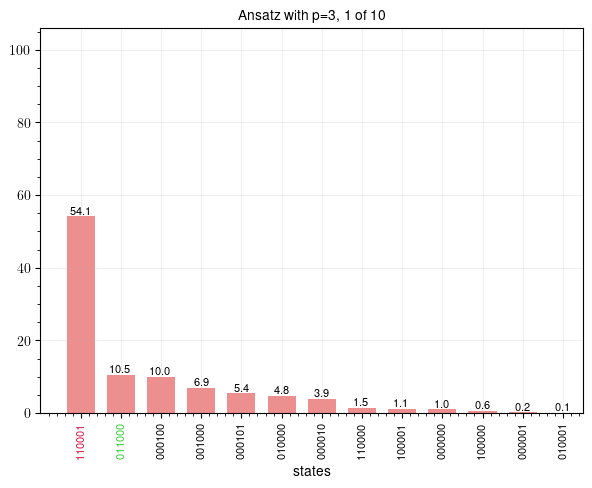

...UPDATING...


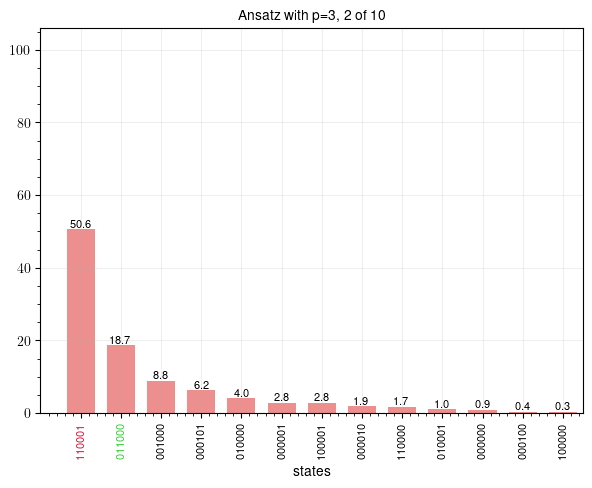

...UPDATING...


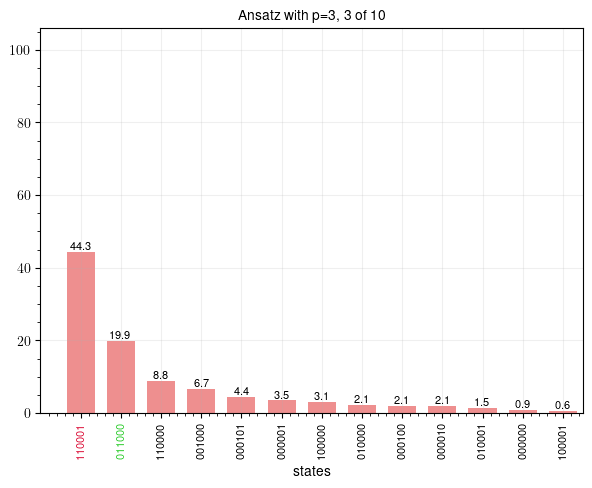

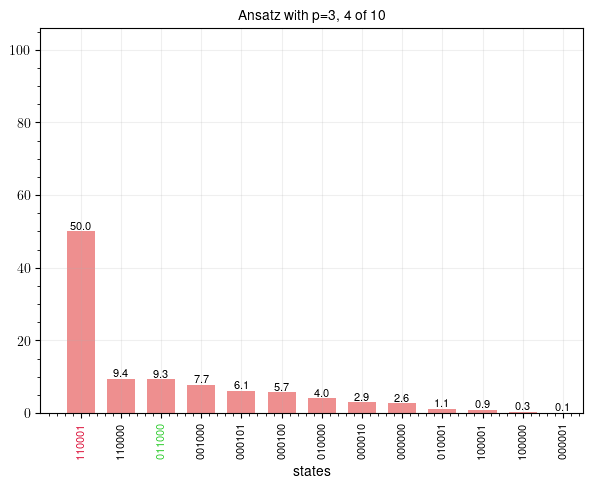

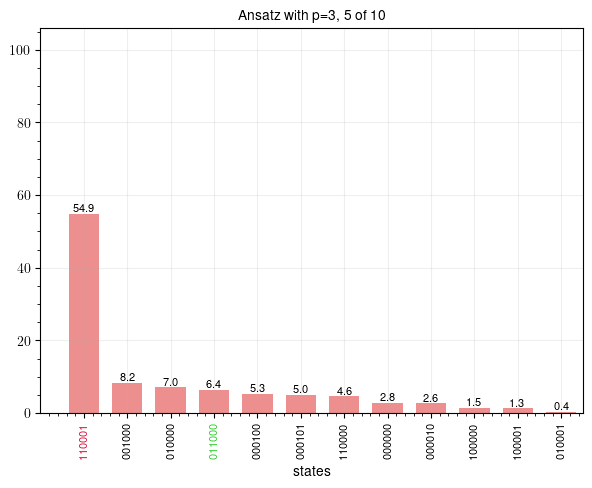

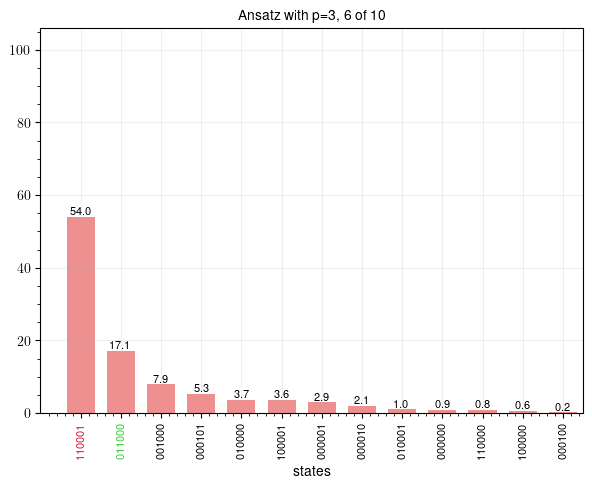

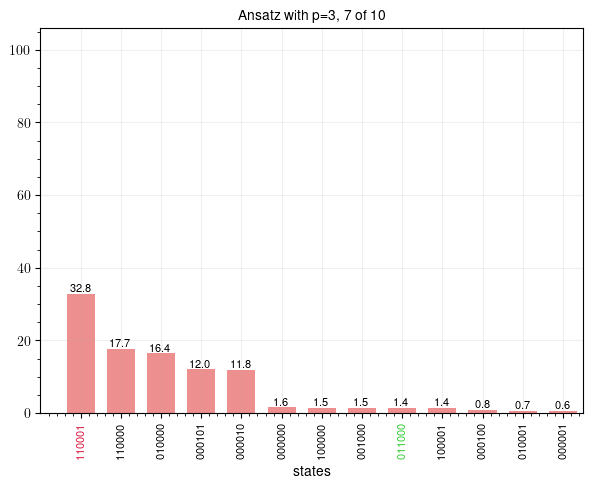

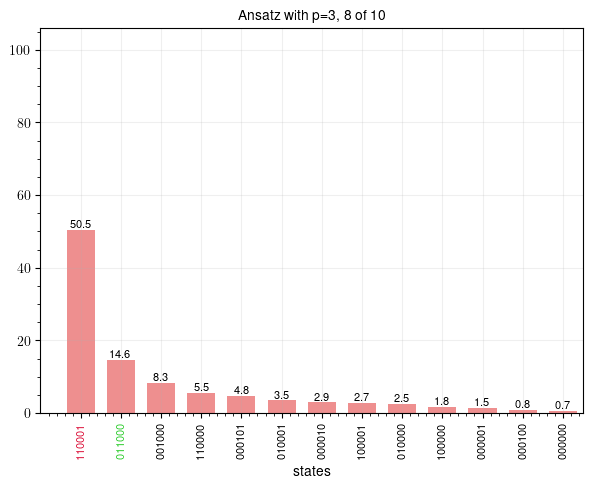

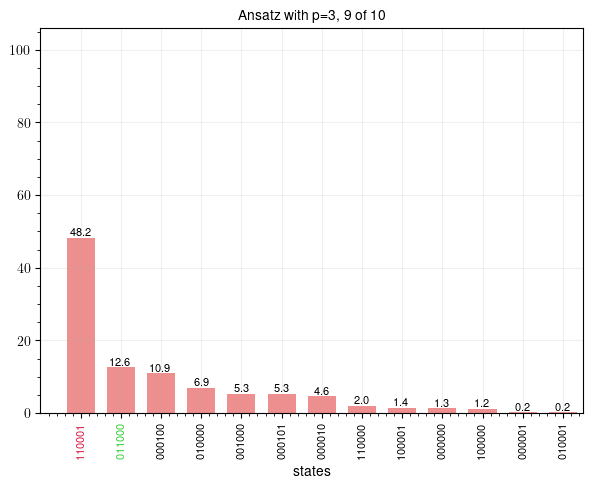

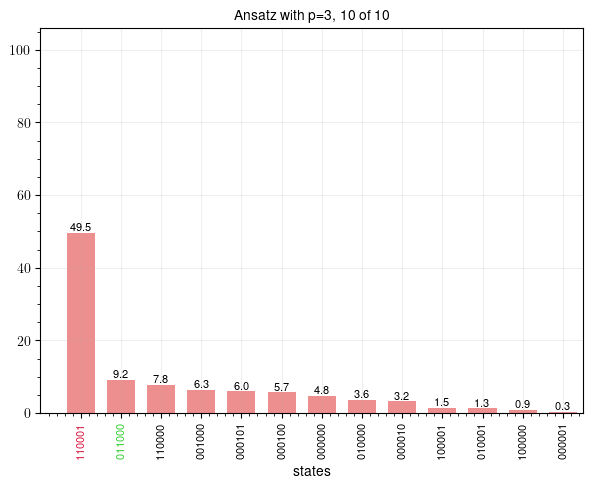

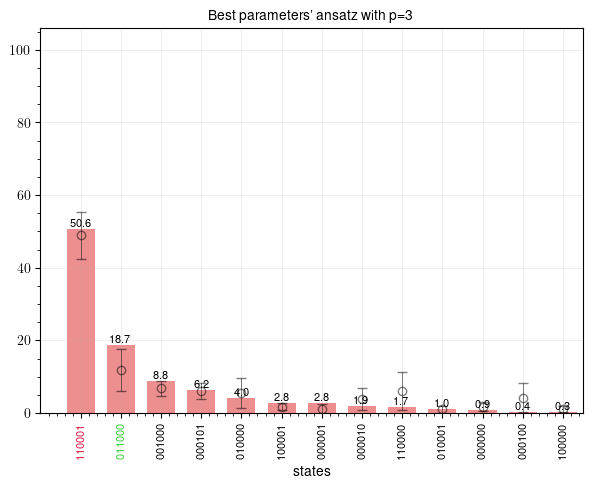


BEST PARAMETERS OFù p=3 LAYER: betas, gammas =  [1.2683407583279769, 2.1578630714362568, 0.6416789482210897] [-1.1360816810085812e-06, 65.32599283968149, -132.34209017928418]
Execution time of p=3 layer: 5.6 min

TOTAL ELAPSED TIME: 8.210046390692392 minutes.
kMEC_06-10_dim6_mail4_all1_p3_10ra_k0.112_BOUNDS[0,2pi]x[-217,217]_pars0[0,2pi]x[-217,217]

 **** p = 1 **** 


<Figure size 640x480 with 0 Axes>

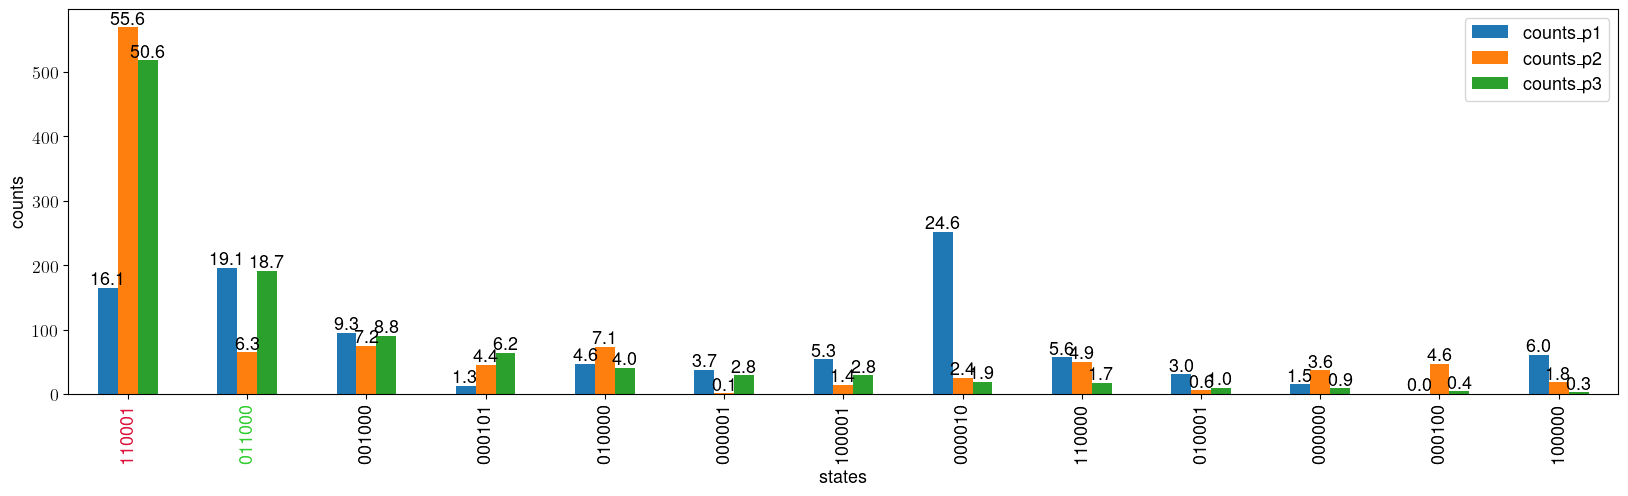

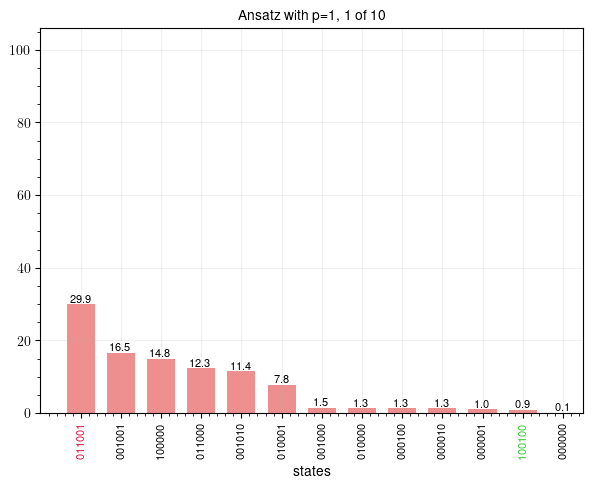

...UPDATING...


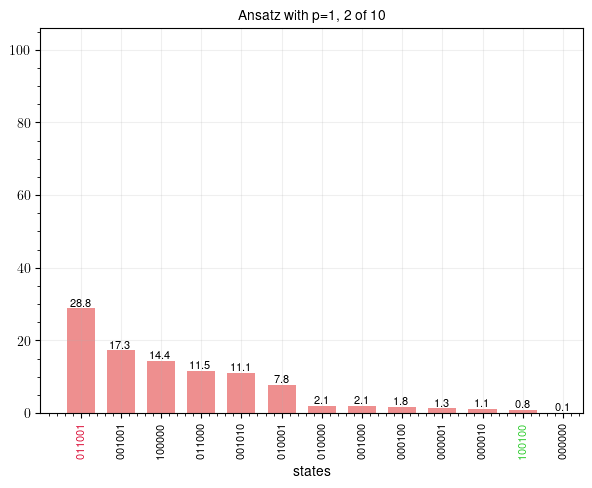

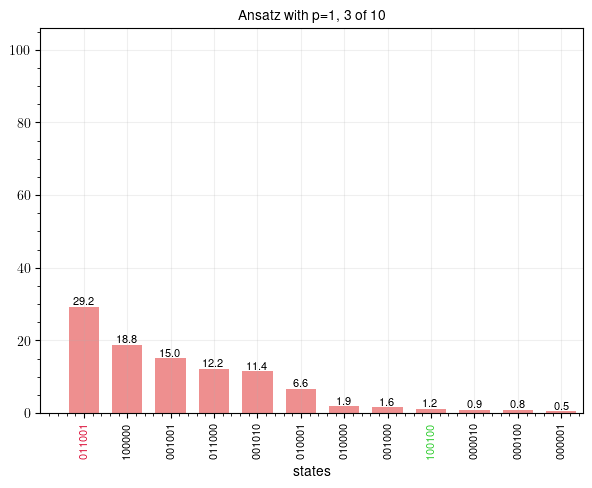

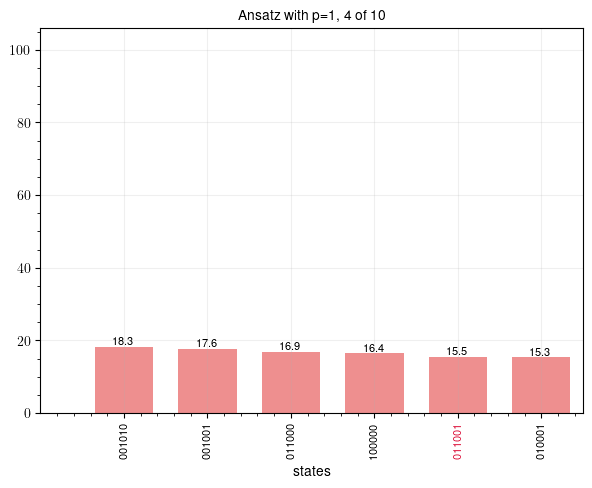

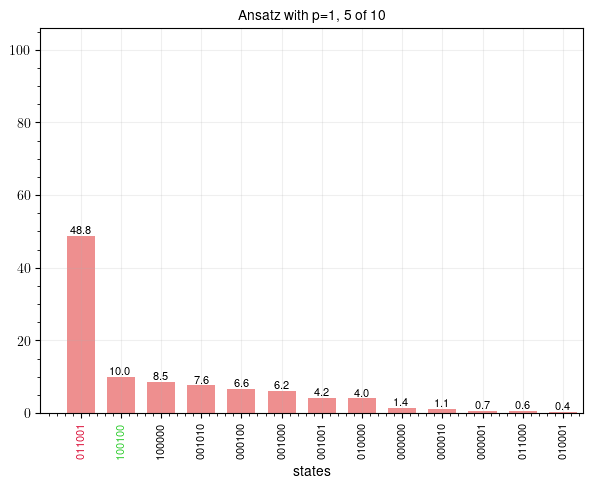

...UPDATING...


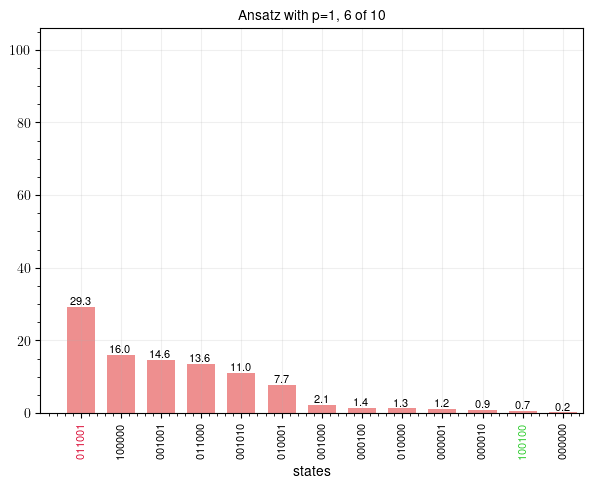

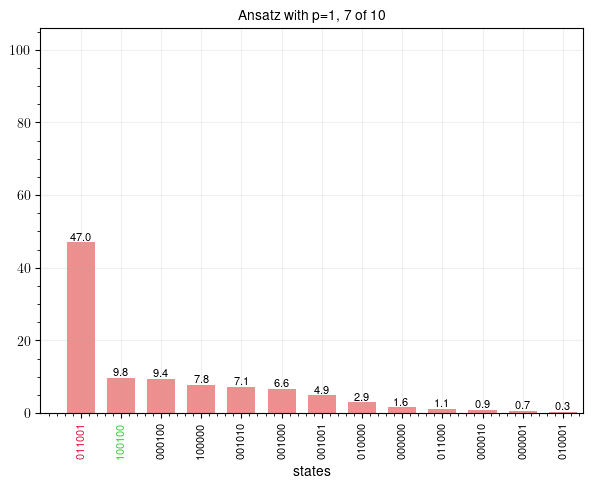

...UPDATING...


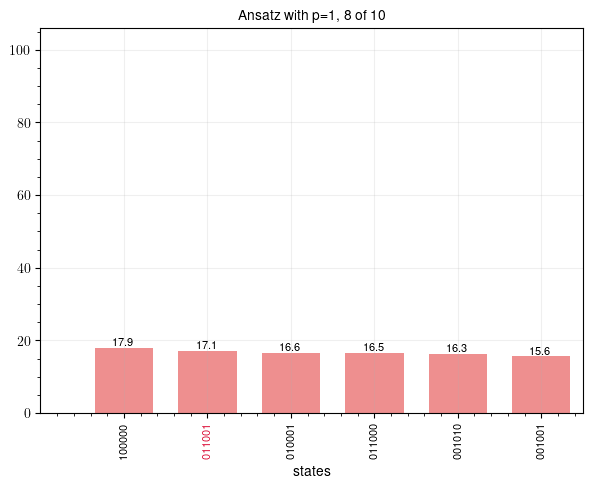

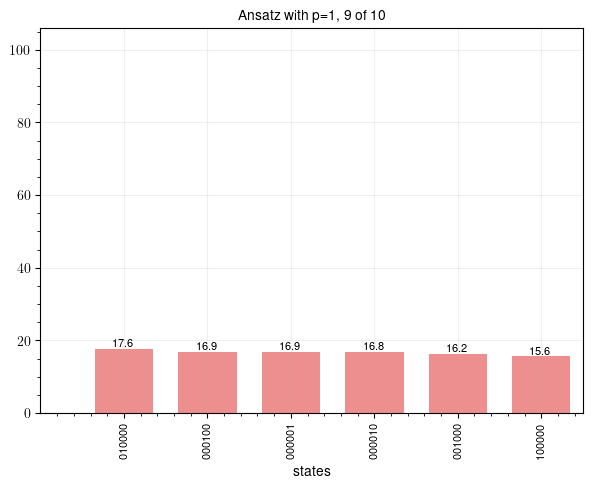

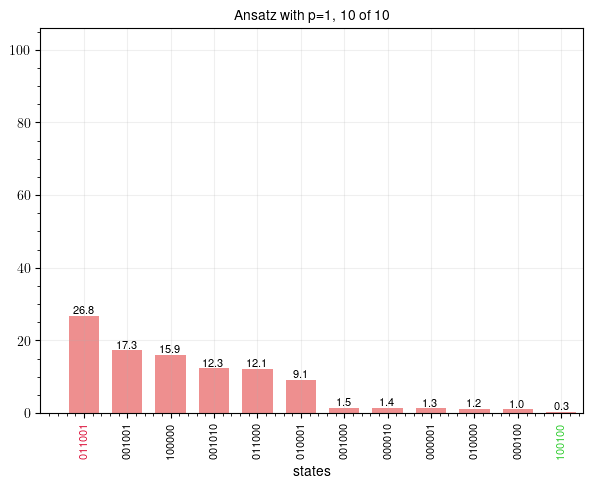

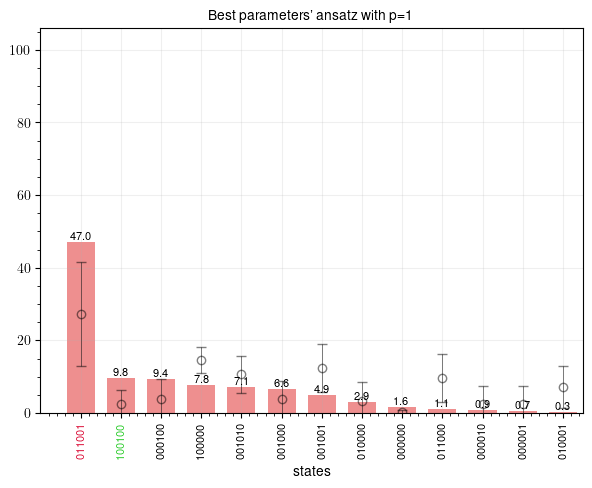


BEST PARAMETERS OFù p=1 LAYER: betas, gammas =  [3.9463525414813647] [1.915671253493195e-05]
Execution time of p=1 layer: 0.8 min

 **** p = 2 **** 


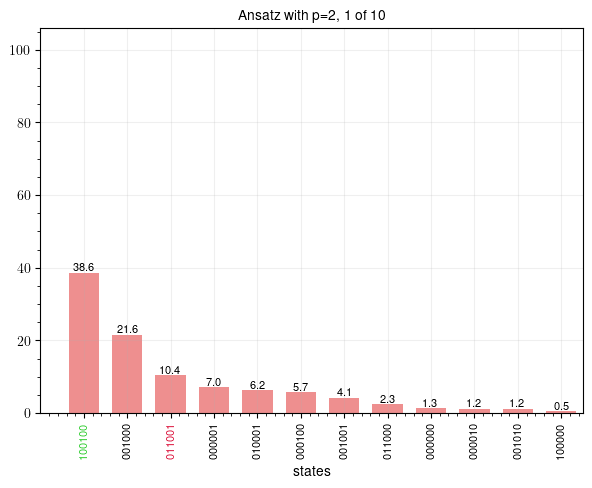

...UPDATING...


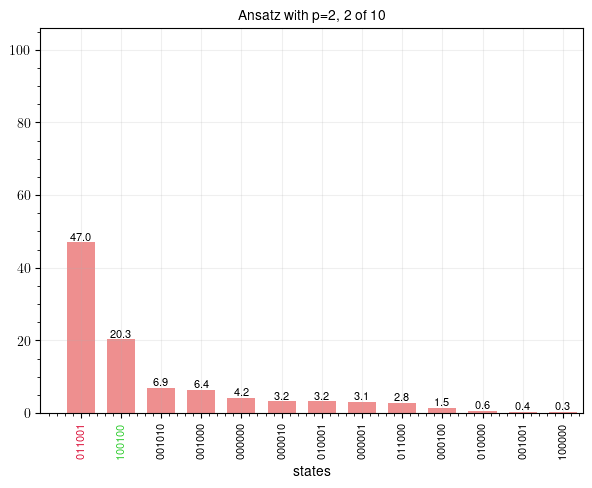

...UPDATING...


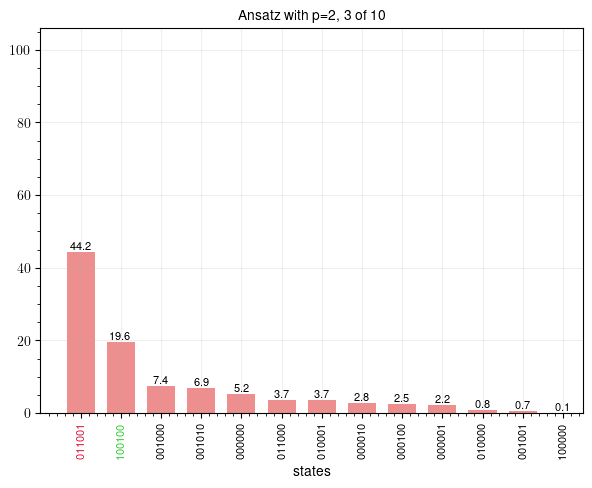

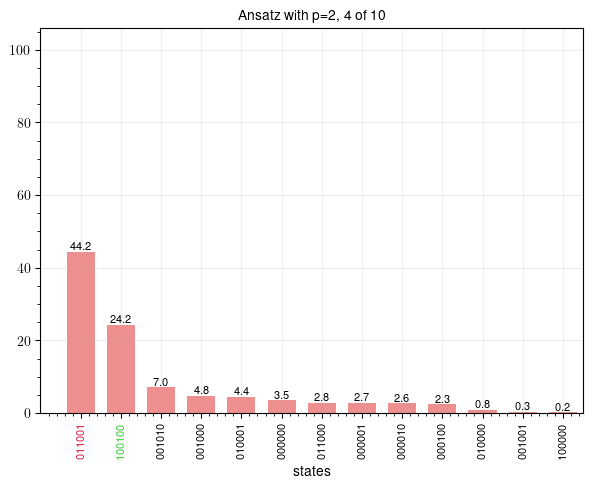

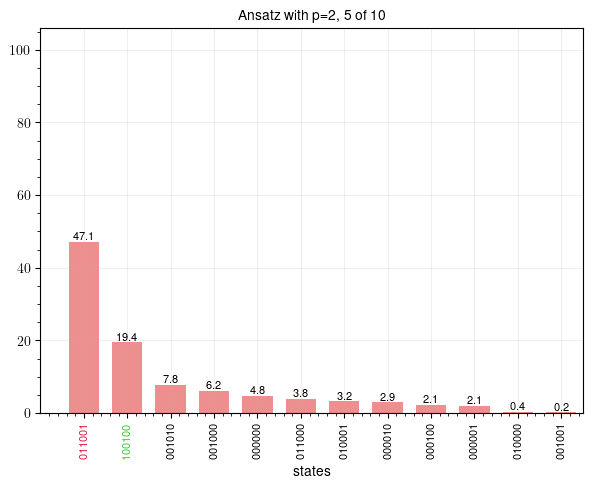

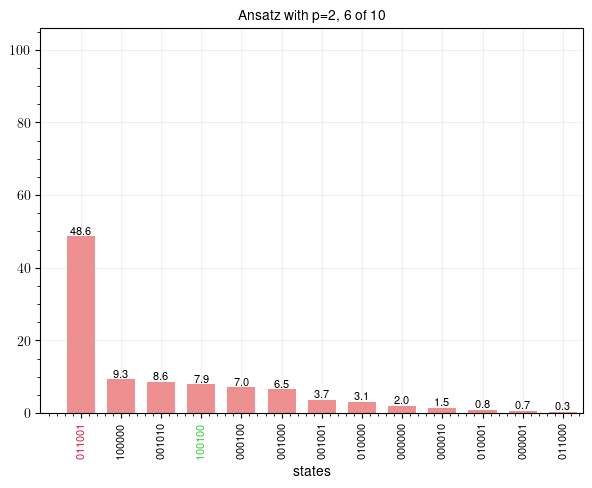

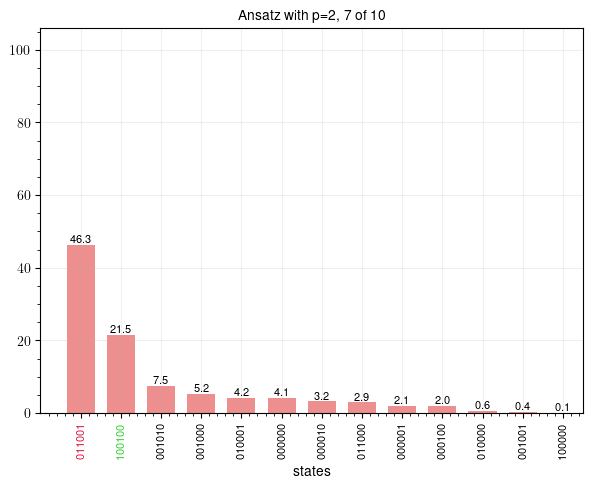

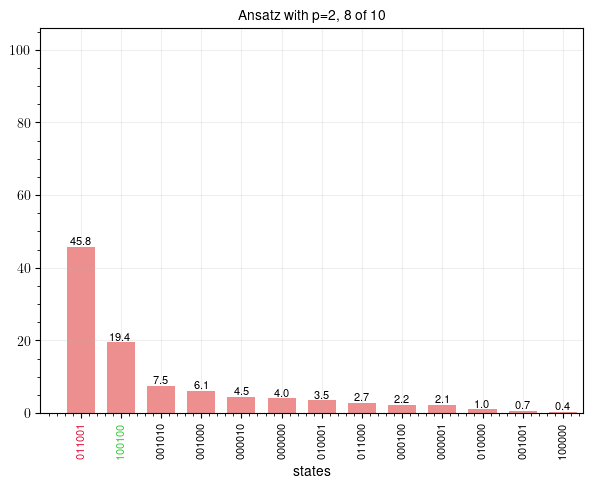

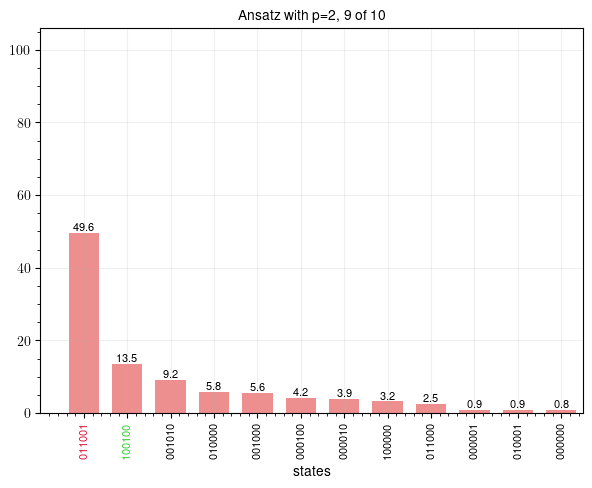

...UPDATING...


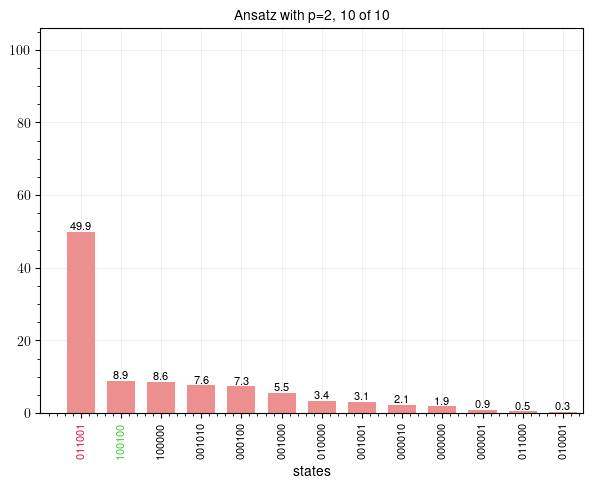

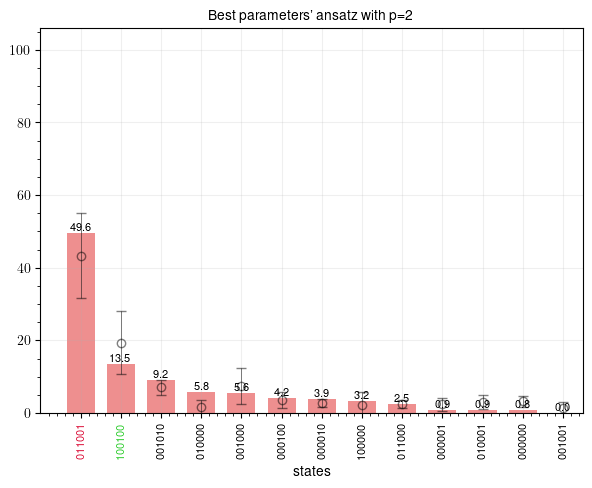


BEST PARAMETERS OFù p=2 LAYER: betas, gammas =  [3.974576814824886, 5.813178046751439] [1.7567234854312277e-05, -107.24916656875178]
Execution time of p=2 layer: 1.8 min

 **** p = 3 **** 


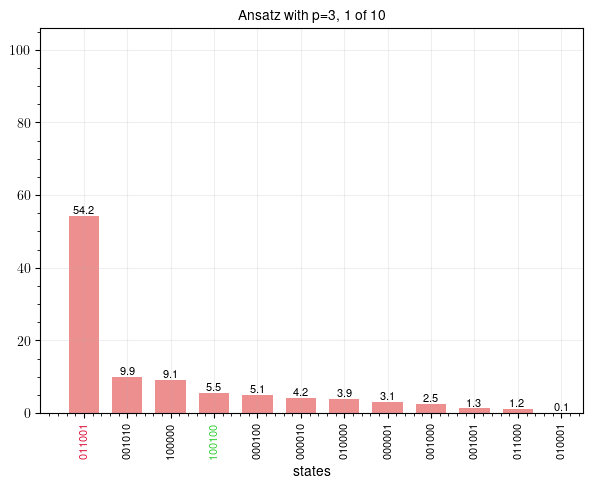

...UPDATING...


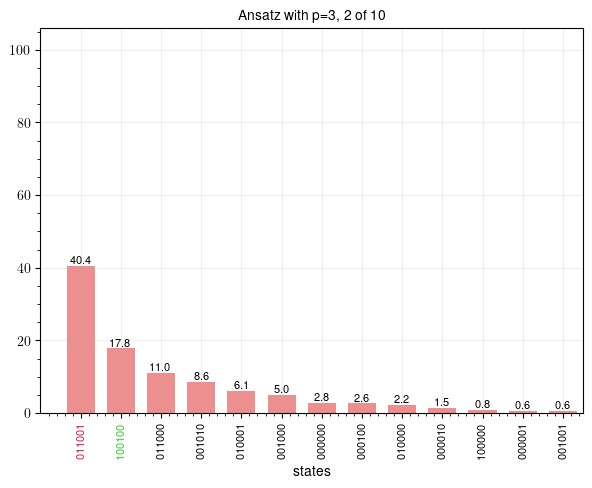

...UPDATING...


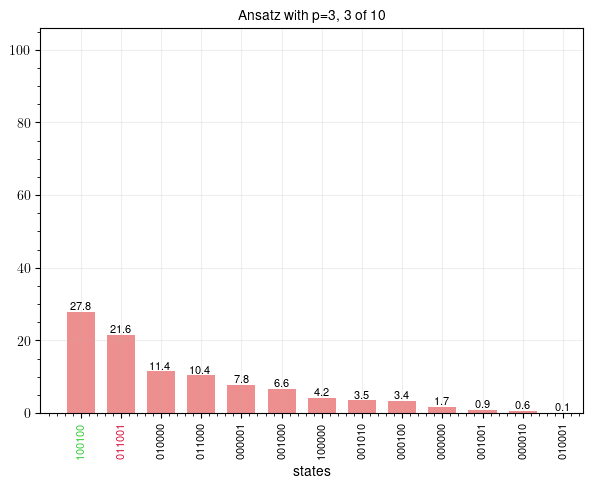

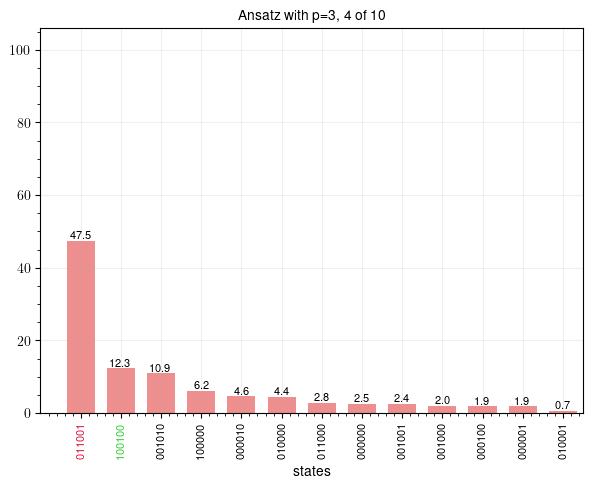

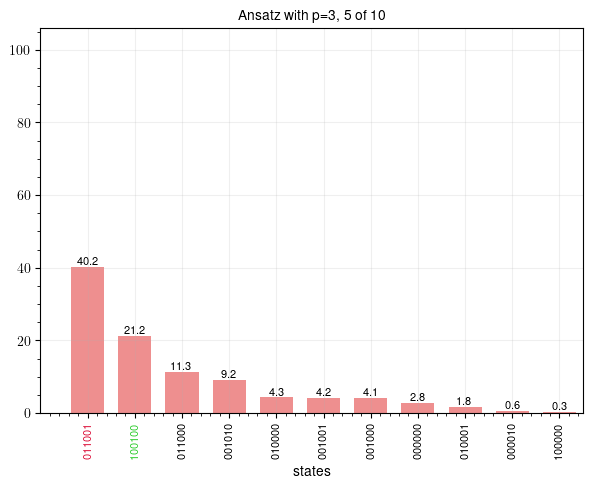

...UPDATING...


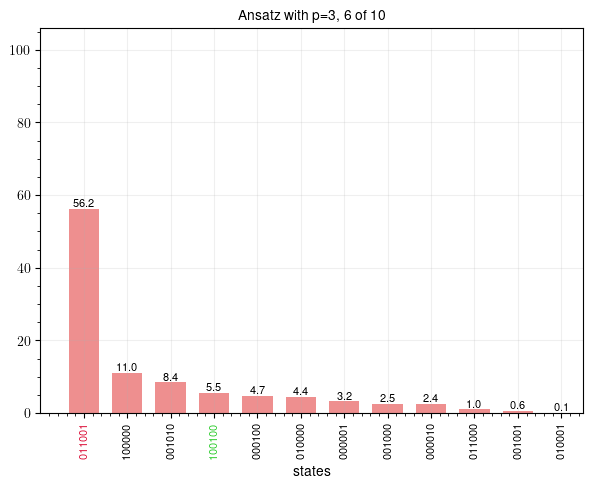

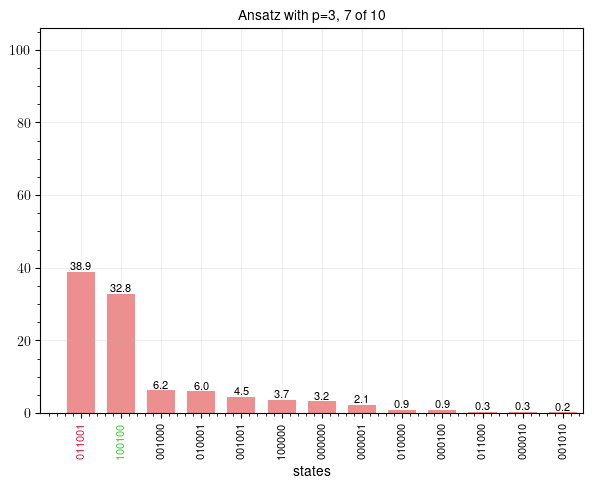

...UPDATING...


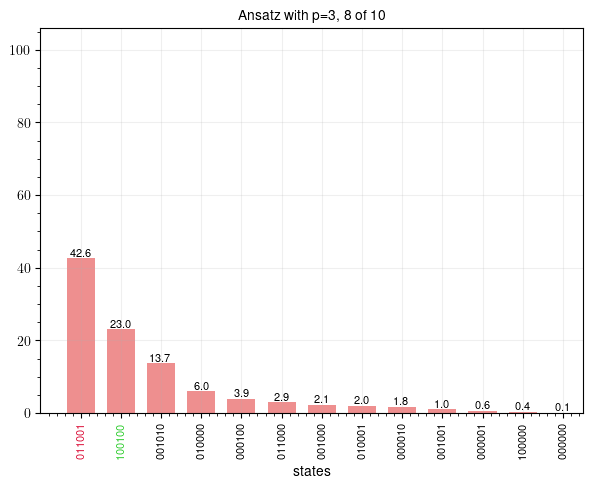

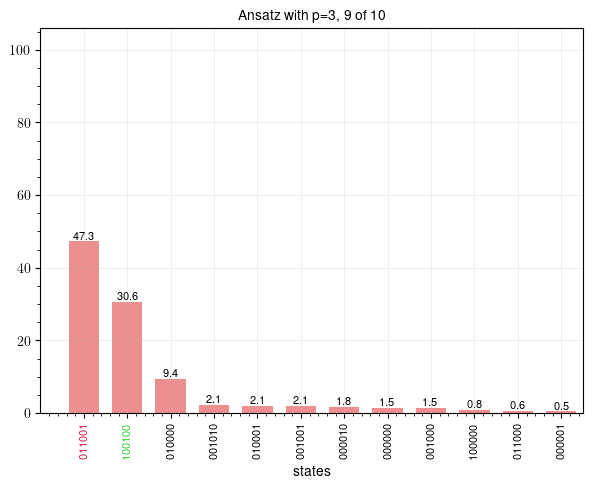

...UPDATING...


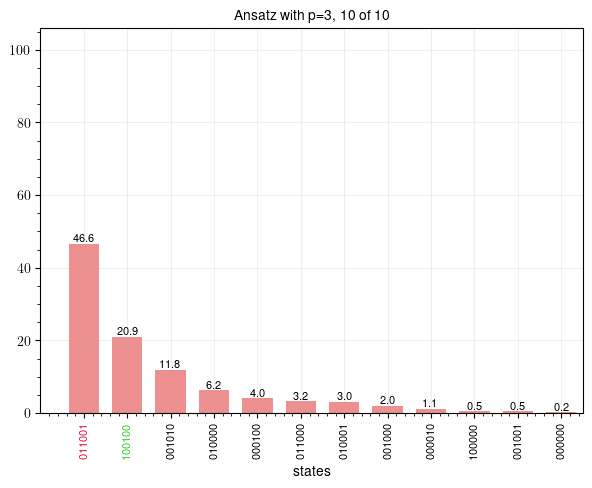

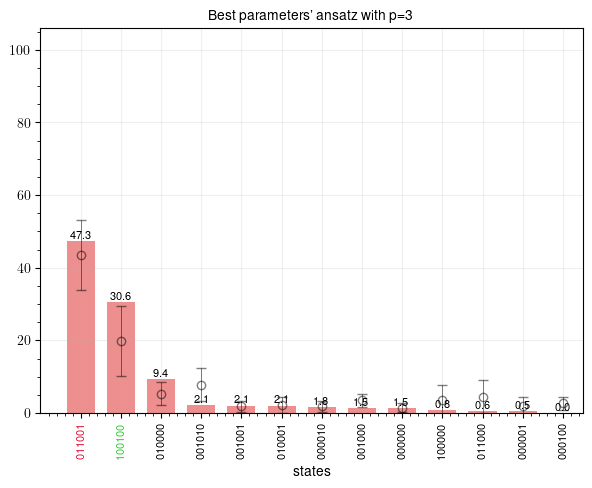


BEST PARAMETERS OFù p=3 LAYER: betas, gammas =  [4.623895571869413, 5.433175893978625, 5.235611217952389] [1.5911675295211715e-05, -96.88481514596236, 92.75495939032614]
Execution time of p=3 layer: 6.6 min

TOTAL ELAPSED TIME: 9.157060849666596 minutes.
kMEC_06-10_dim6_mail5_all1_p3_10ra_k0.167_BOUNDS[0,2pi]x[-220,220]_pars0[0,2pi]x[-220,220]

 **** p = 1 **** 


<Figure size 640x480 with 0 Axes>

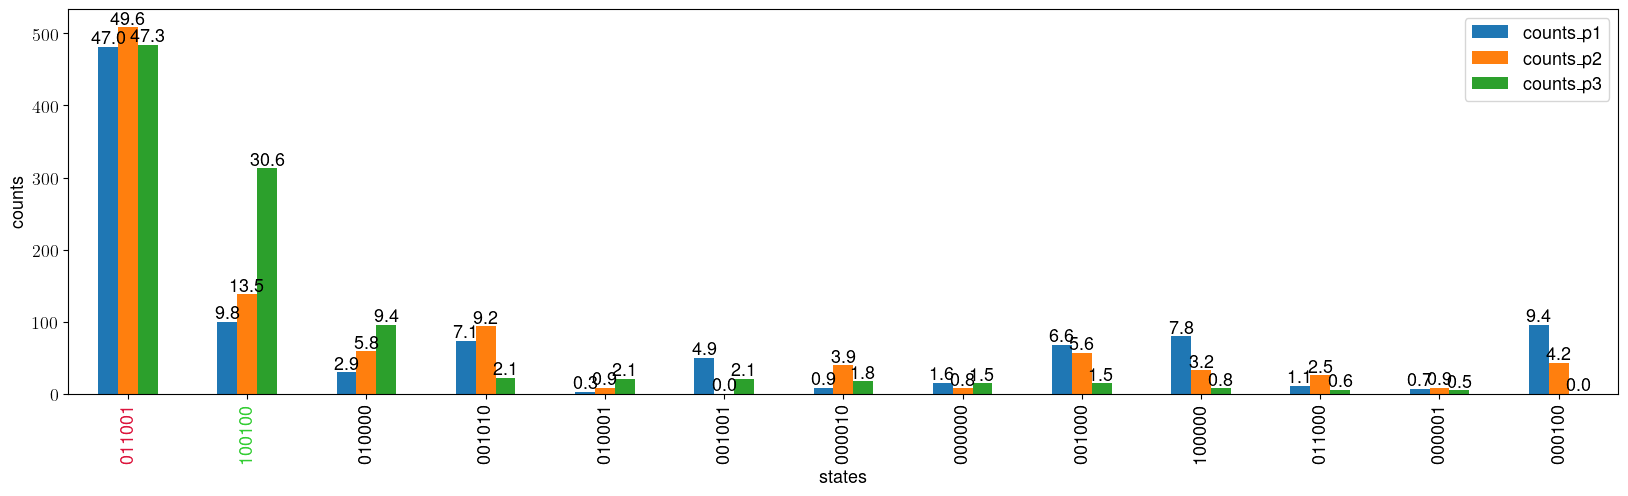

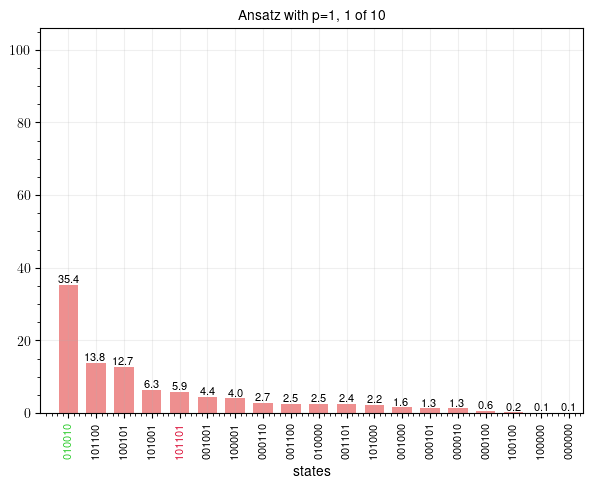

...UPDATING...


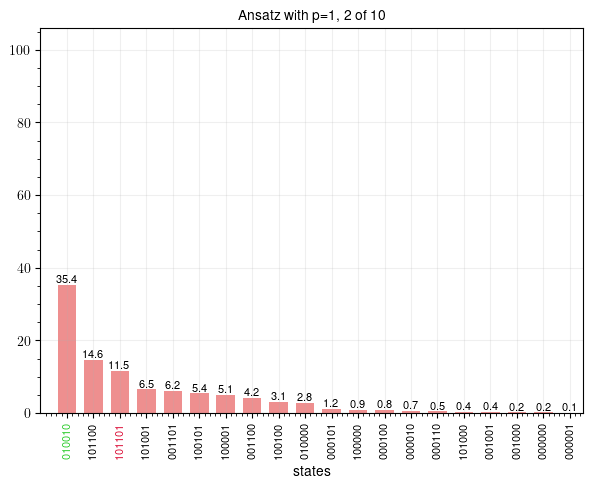

...UPDATING...


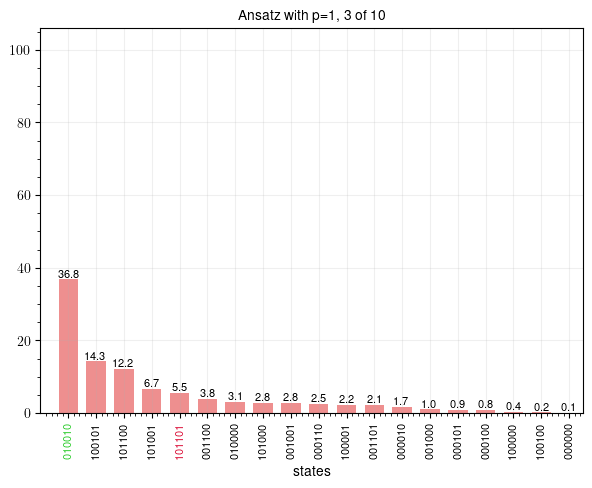

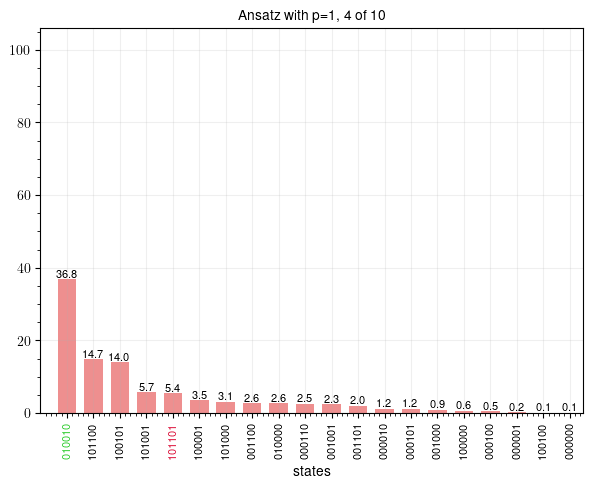

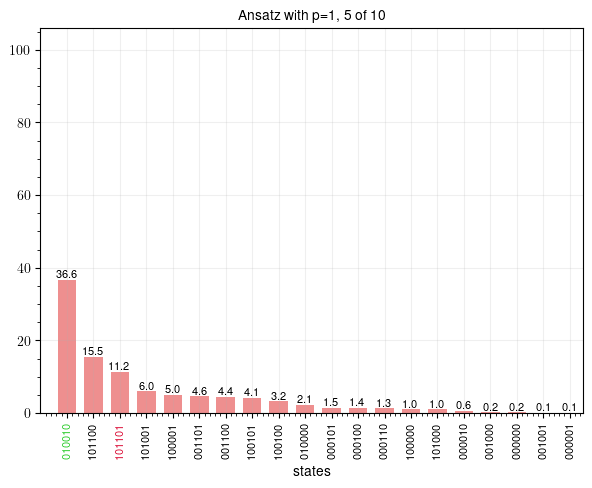

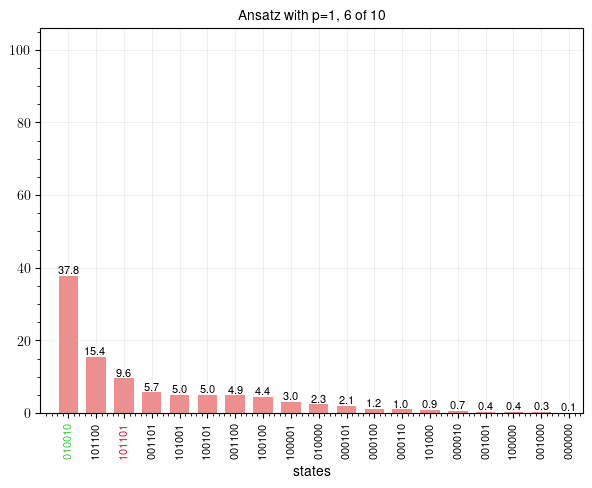

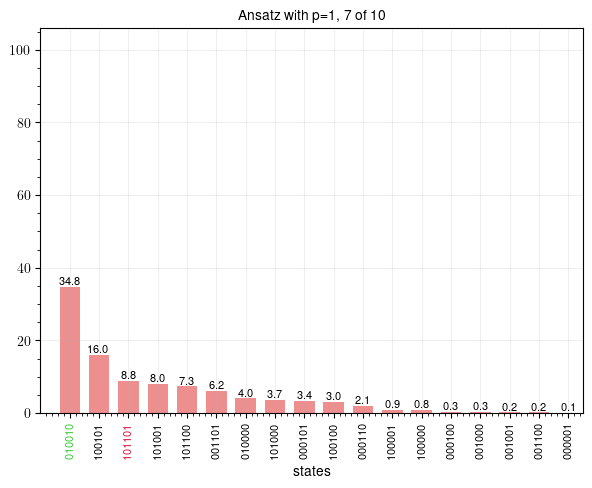

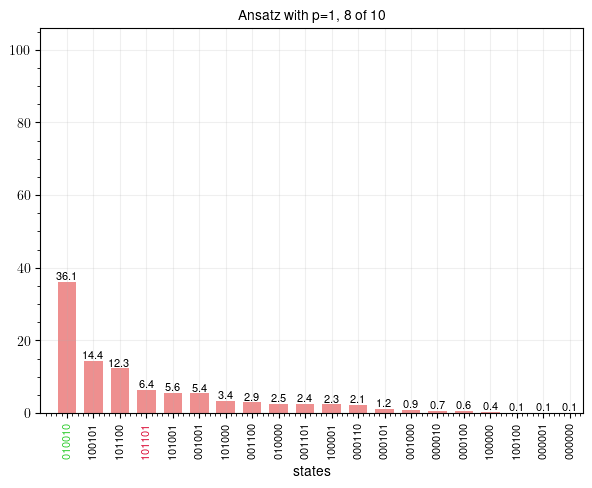

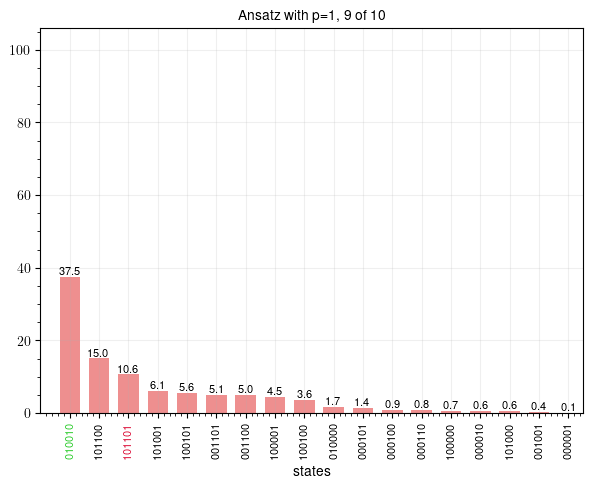

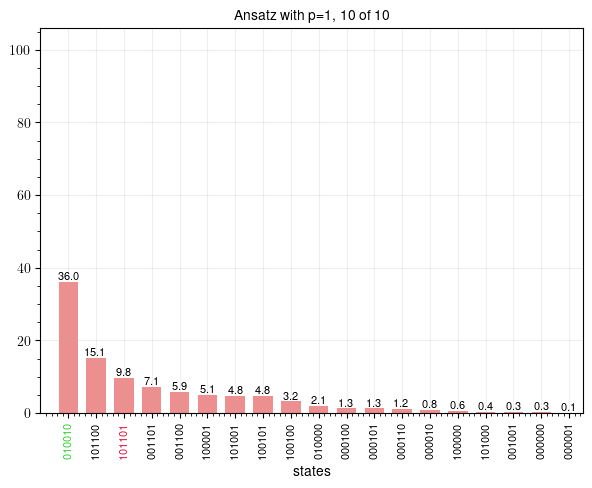

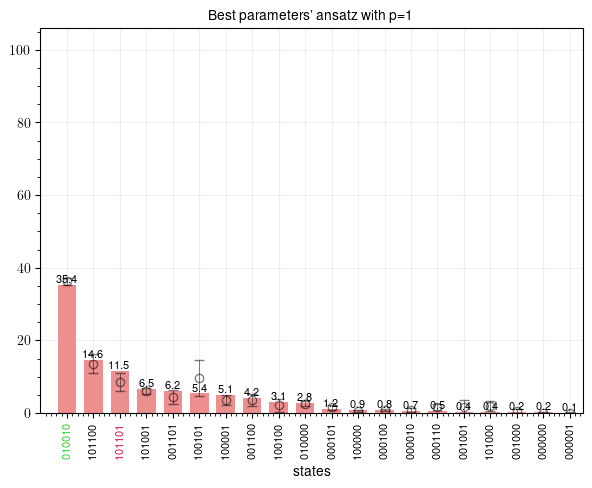


BEST PARAMETERS OFù p=1 LAYER: betas, gammas =  [2.3371744701607926] [164.22473727176373]
Execution time of p=1 layer: 0.6 min

 **** p = 2 **** 


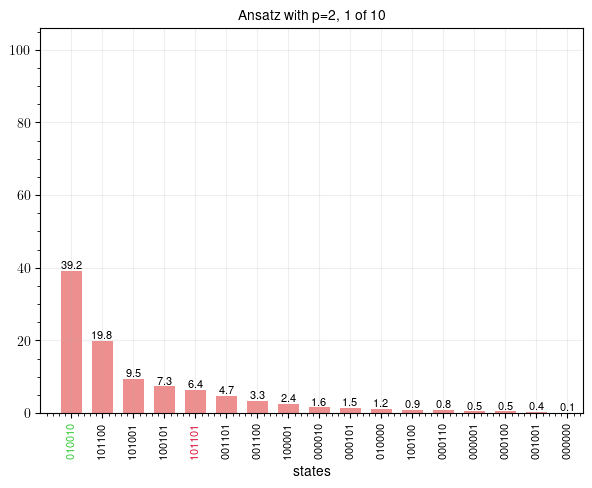

...UPDATING...


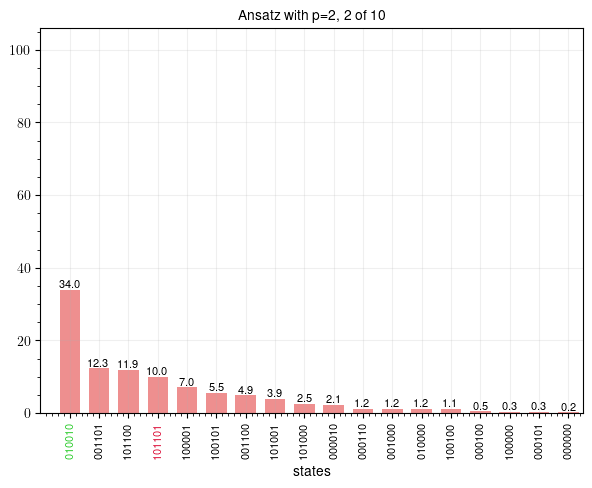

...UPDATING...


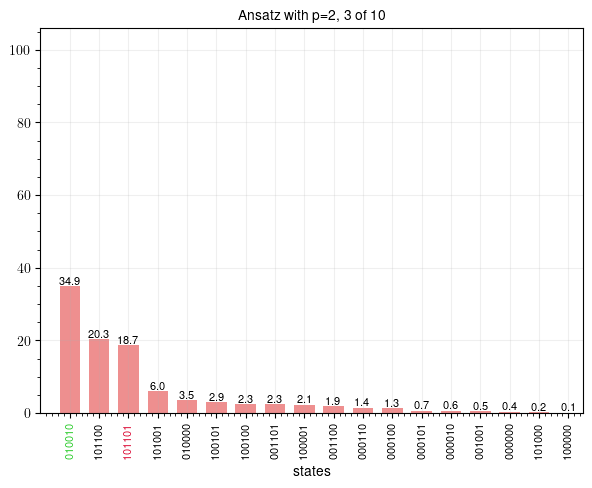

...UPDATING...


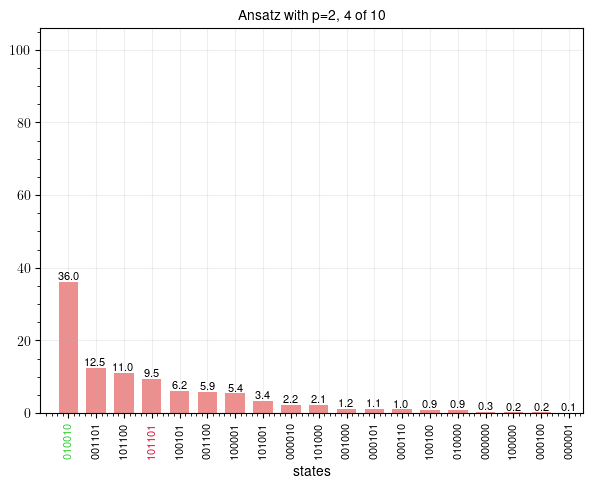

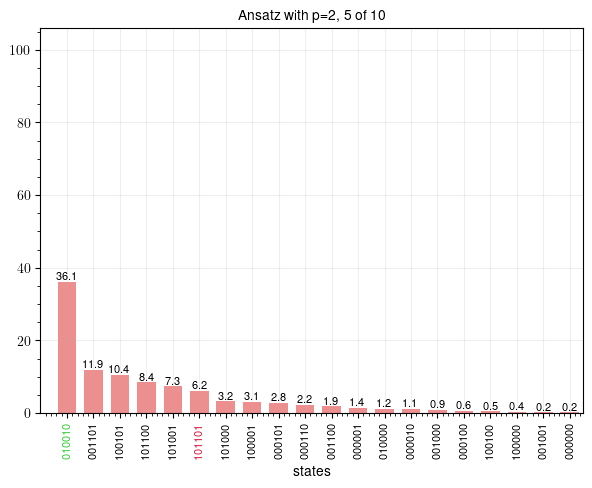

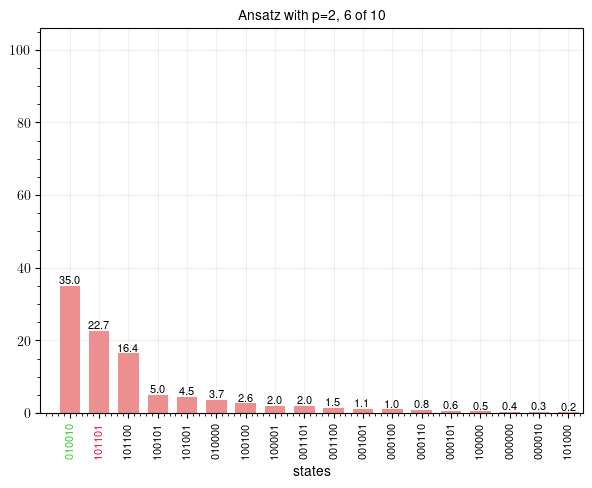

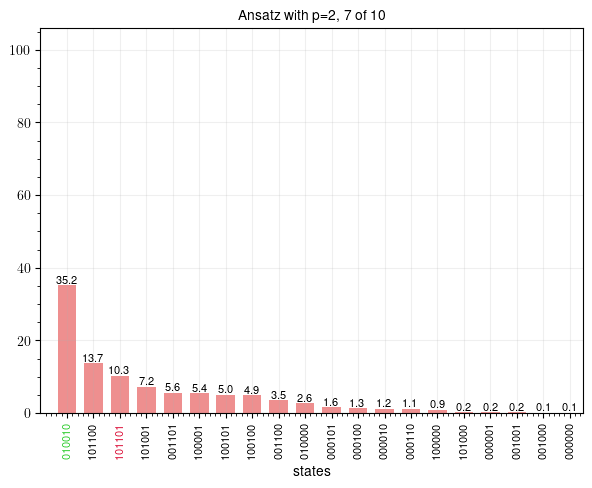

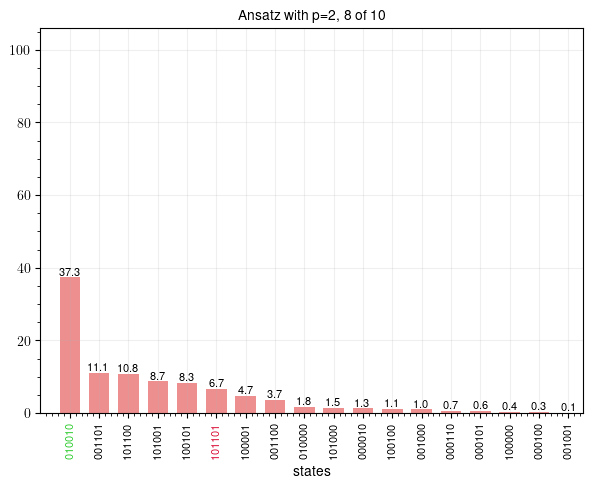

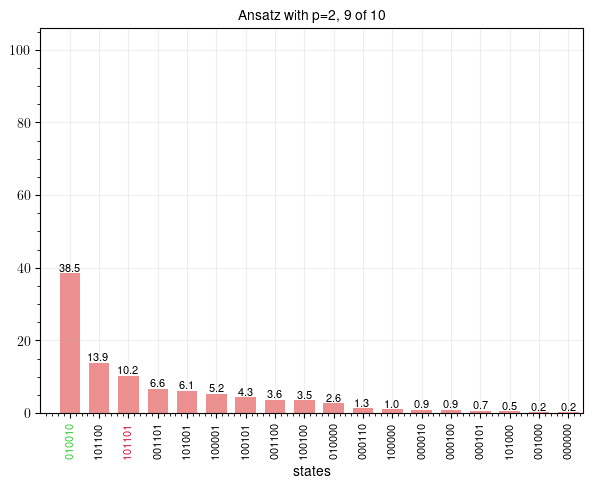

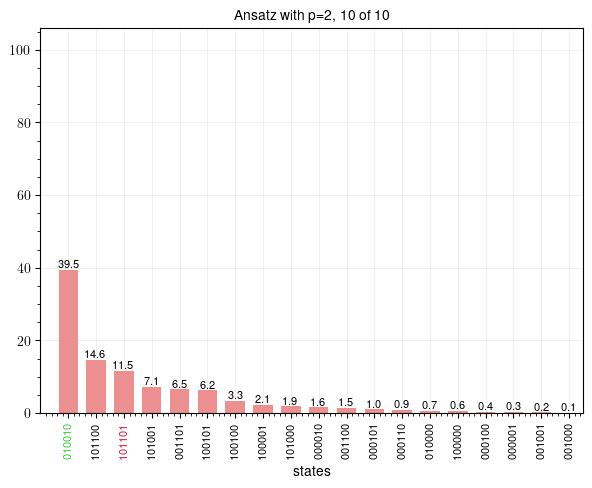

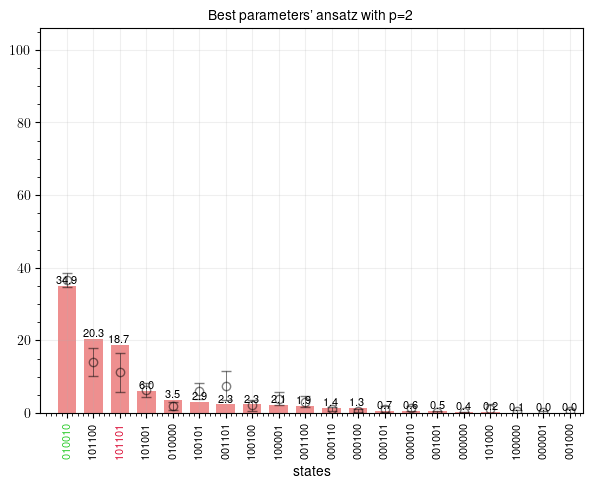


BEST PARAMETERS OFù p=2 LAYER: betas, gammas =  [1.5047042798981707, 0.9831392876704009] [168.41387532628968, -2.4654436612371216]
Execution time of p=2 layer: 1.8 min

 **** p = 3 **** 


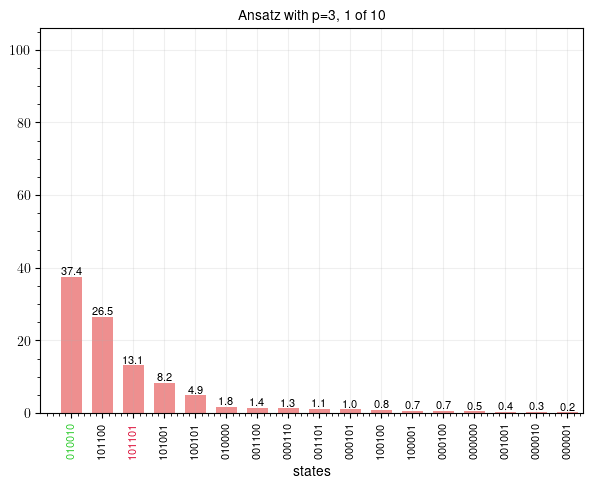

...UPDATING...


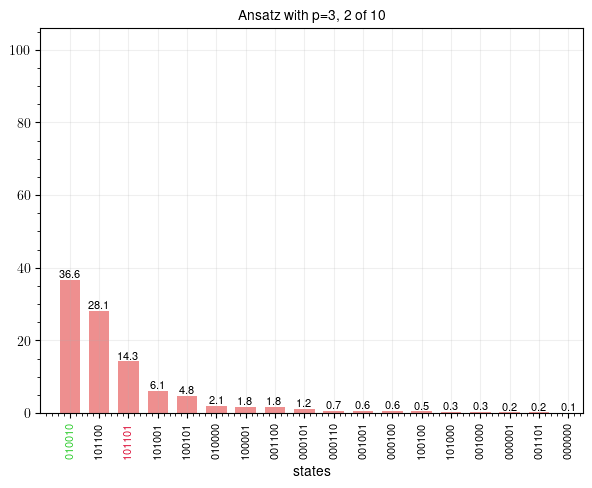

...UPDATING...


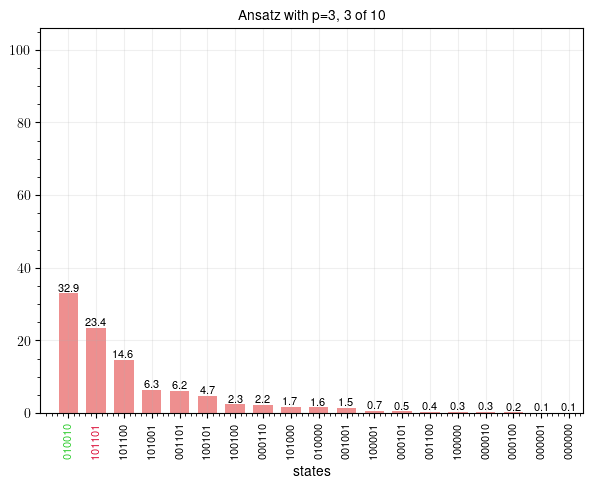

...UPDATING...


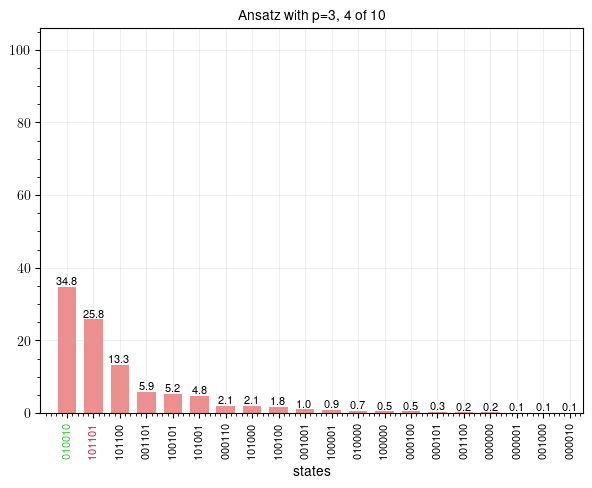

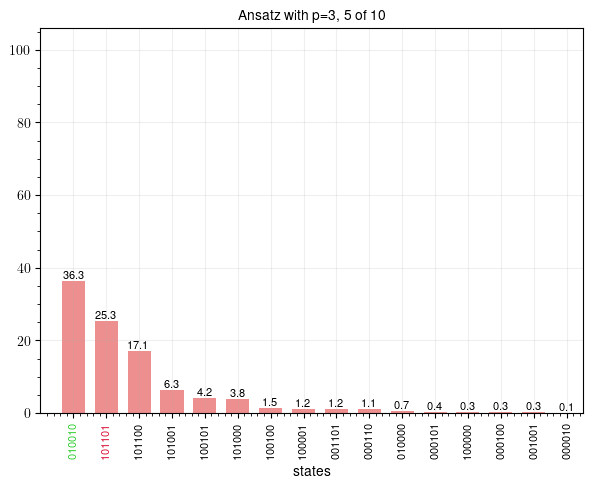

...UPDATING...


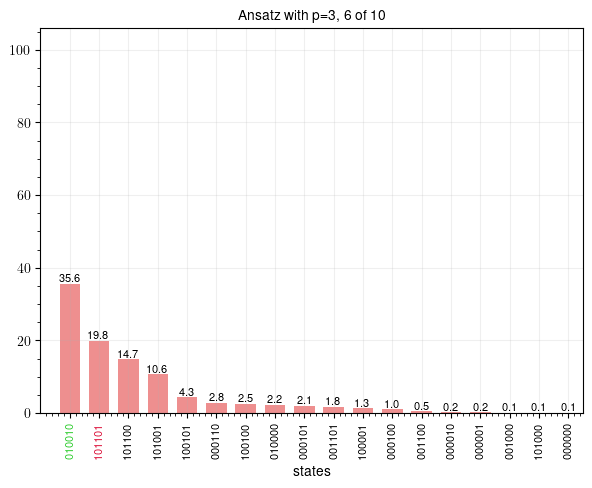

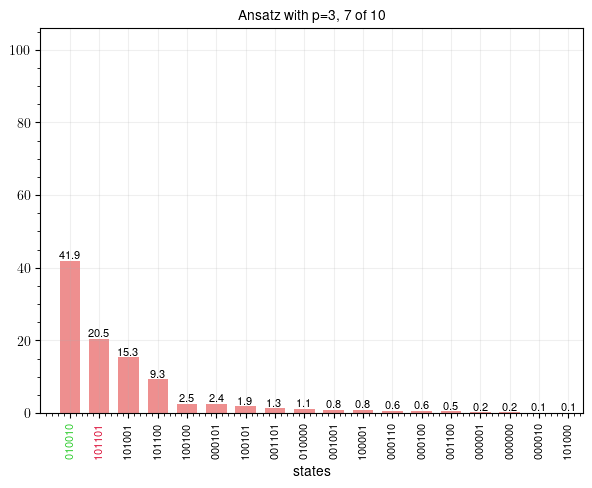

...UPDATING...


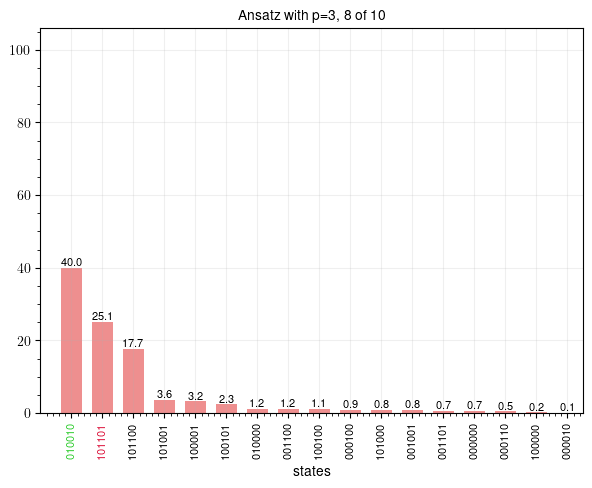

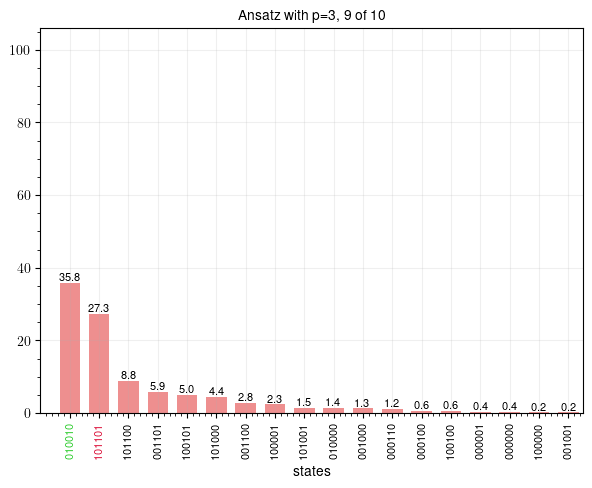

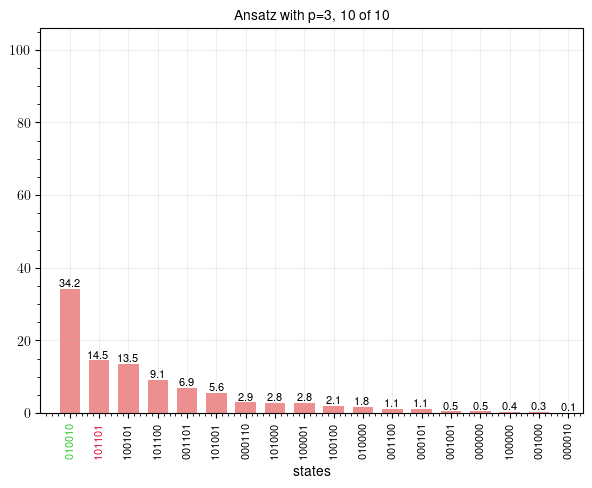

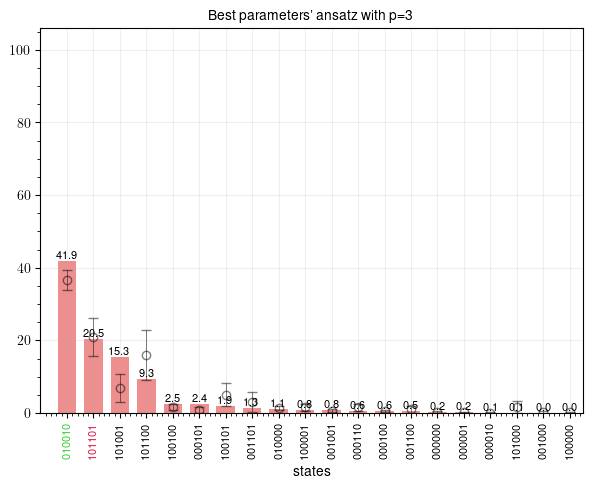


BEST PARAMETERS OFù p=3 LAYER: betas, gammas =  [1.5959474750001905, 1.1785123255123628, 0.6377816678096369] [164.00540468709949, 5.534968843363671, -38.96882282037761]
Execution time of p=3 layer: 5.6 min

TOTAL ELAPSED TIME: 8.037866735458374 minutes.
kMEC_06-10_dim6_mail6_all1_p3_10ra_k0.167_BOUNDS[0,2pi]x[-220,220]_pars0[0,2pi]x[-220,220]

 **** p = 1 **** 


<Figure size 640x480 with 0 Axes>

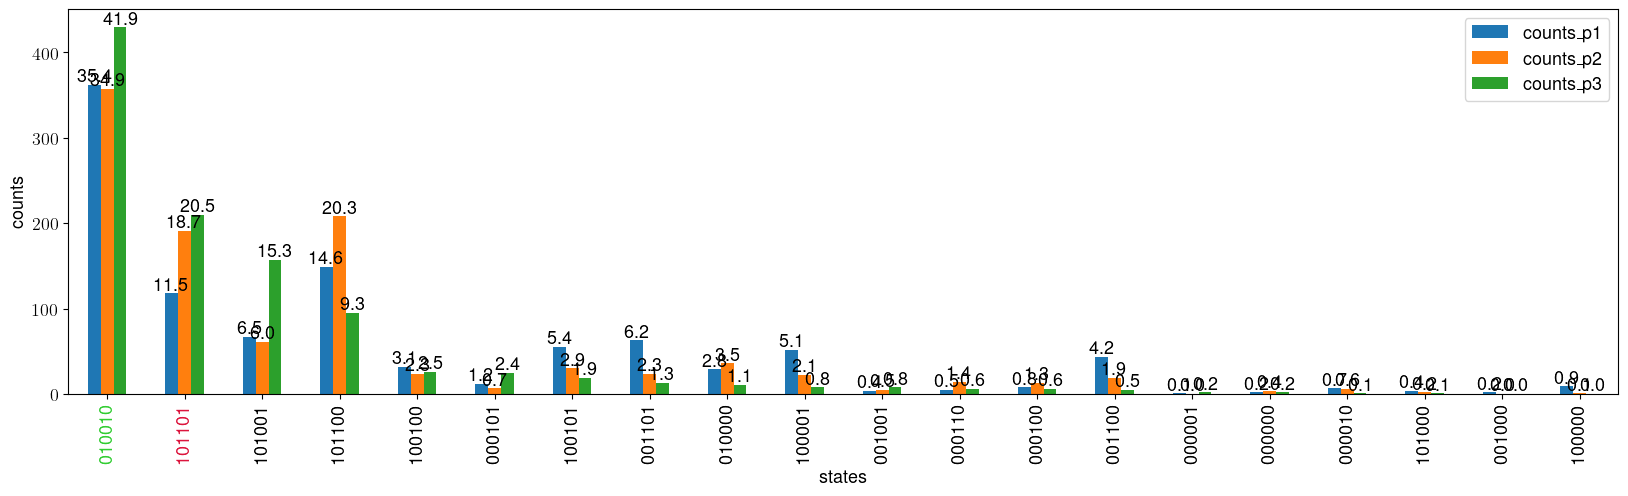

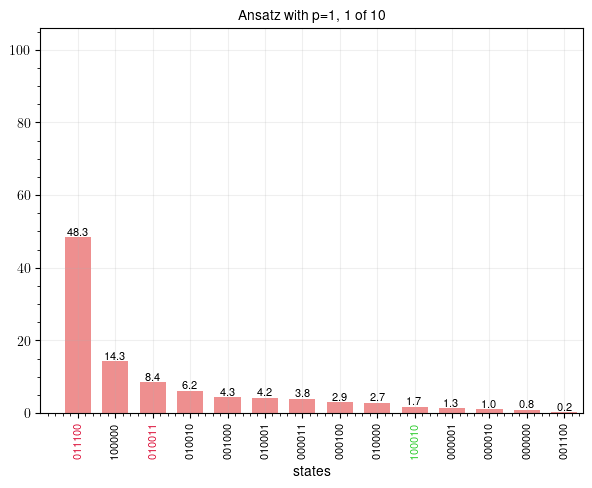

...UPDATING...


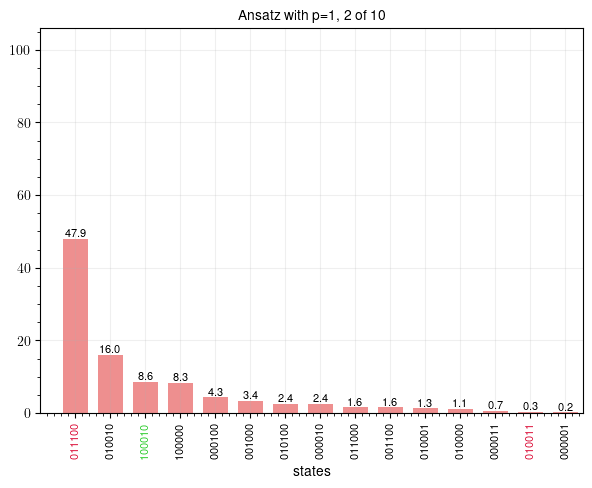

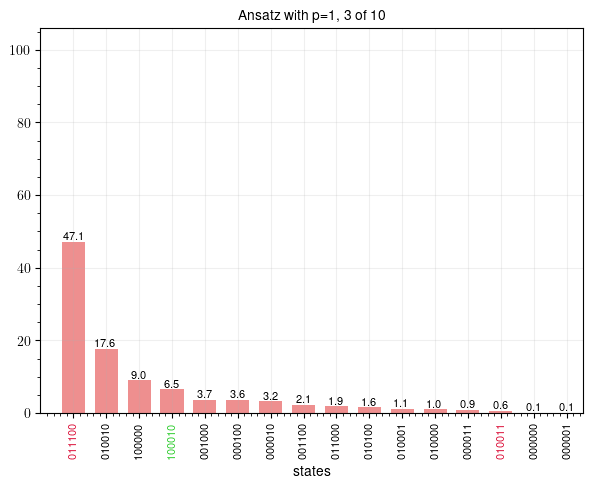

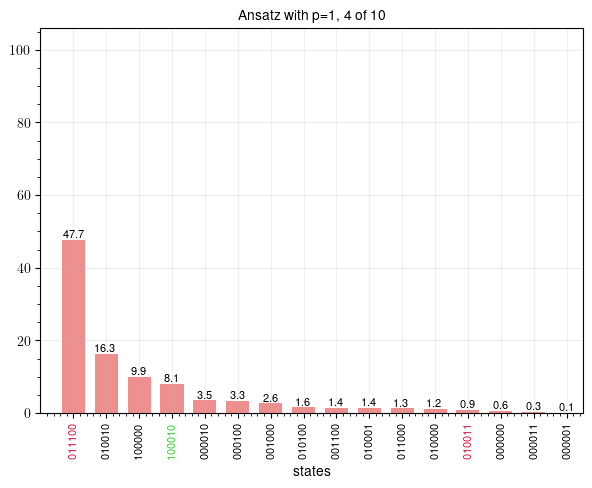

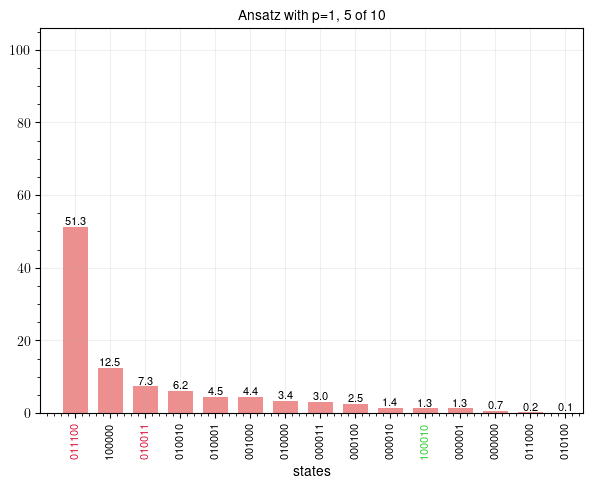

...UPDATING...


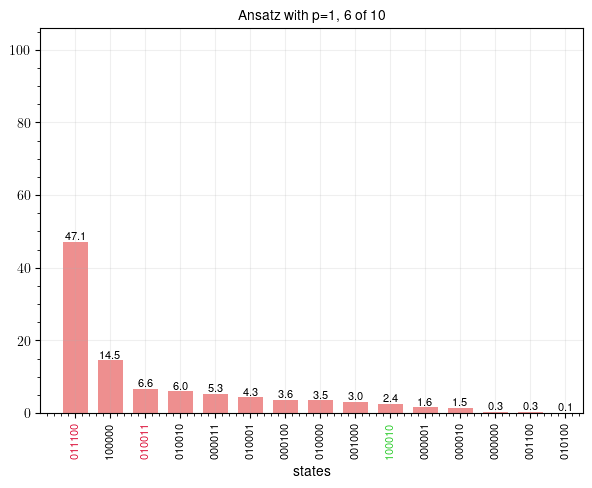

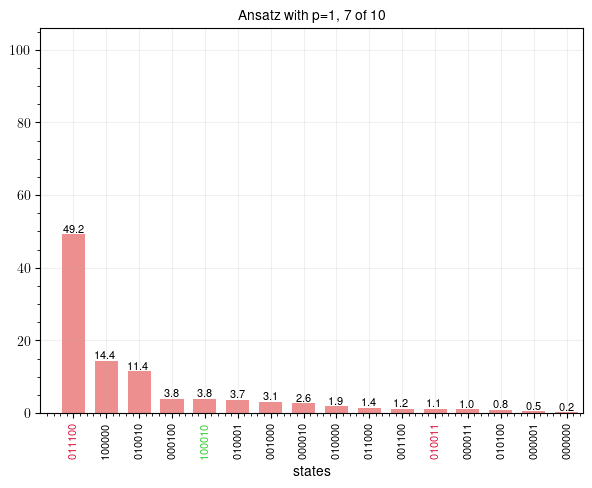

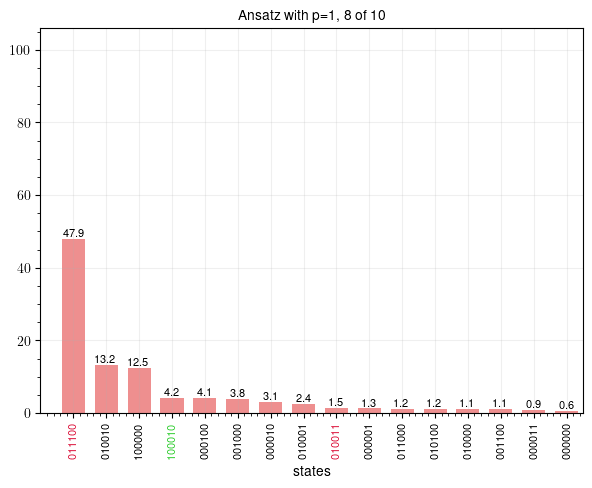

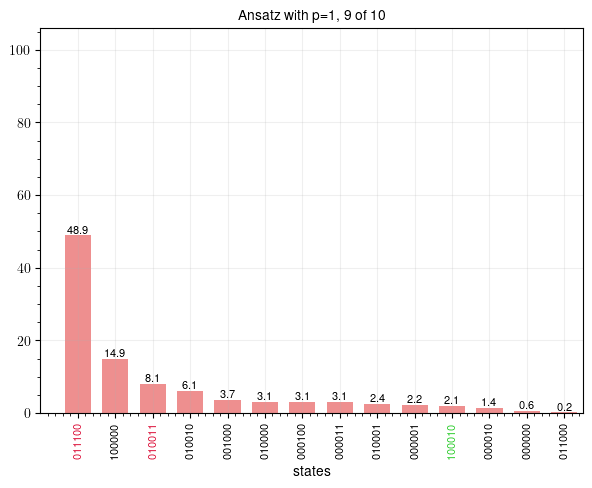

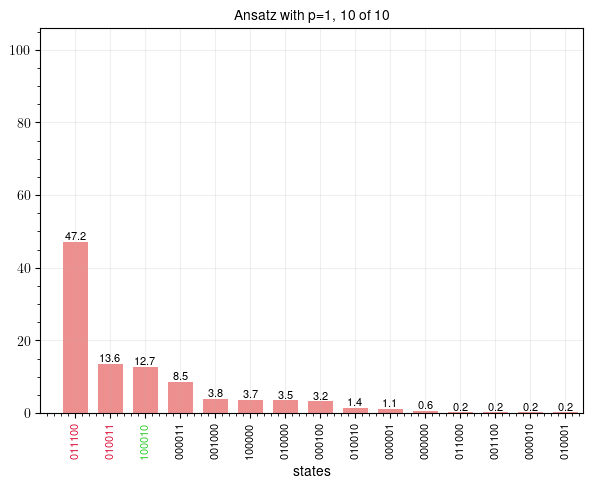

...UPDATING...


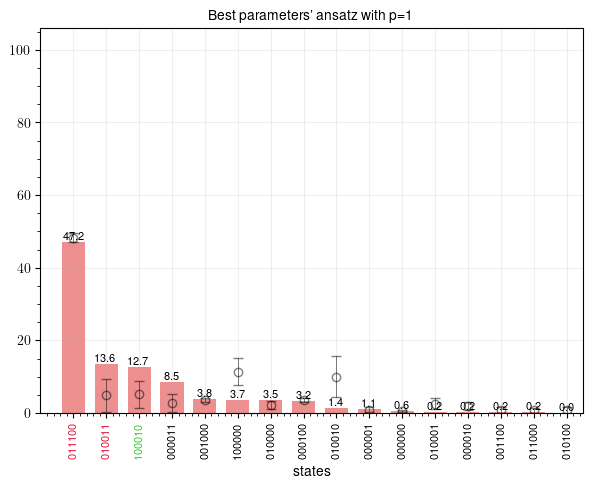


BEST PARAMETERS OFù p=1 LAYER: betas, gammas =  [2.12563664274309] [-109.7362261219952]
Execution time of p=1 layer: 0.6 min

 **** p = 2 **** 


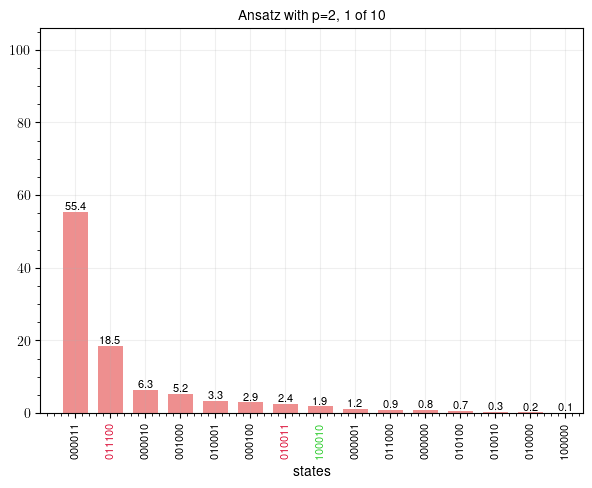

...UPDATING...


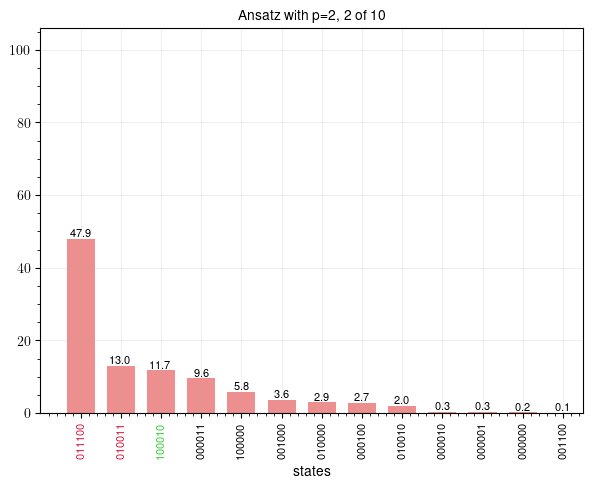

...UPDATING...


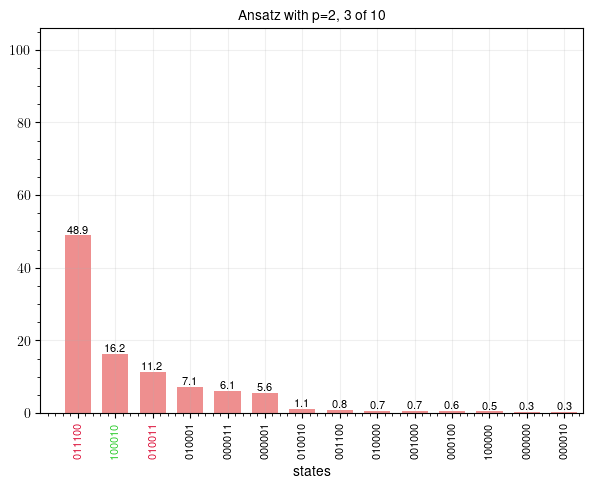

...UPDATING...


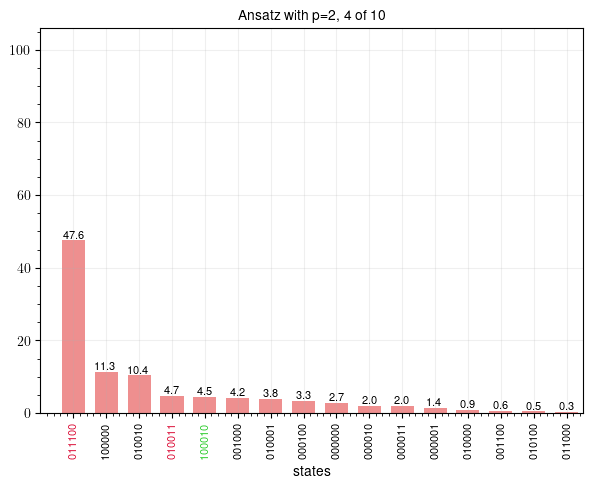

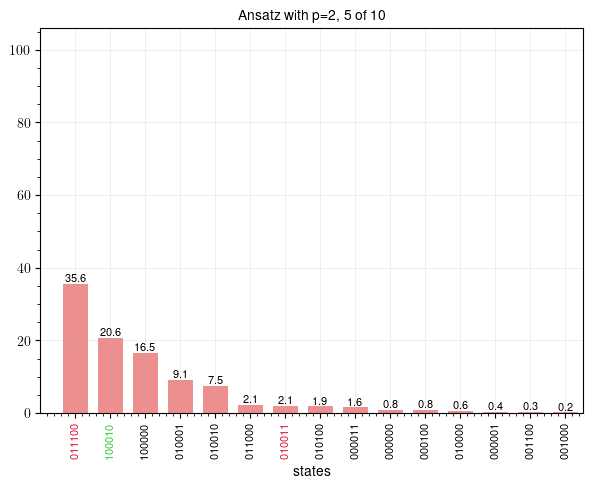

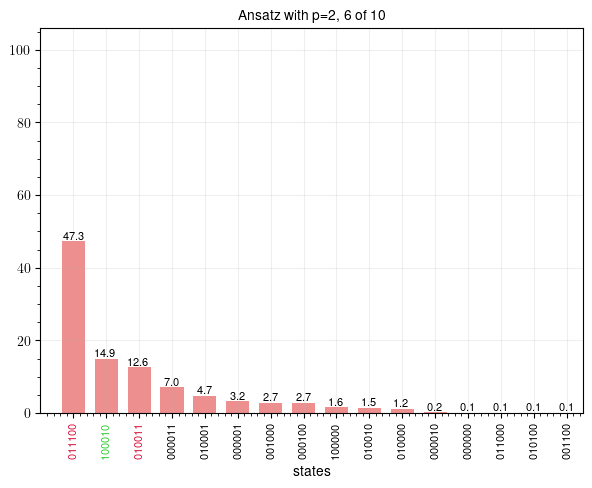

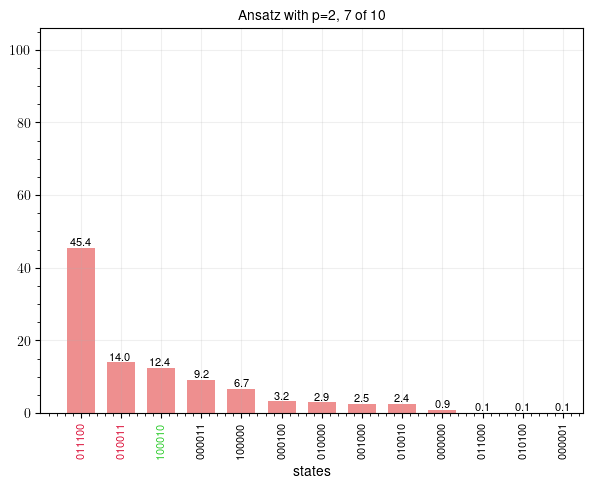

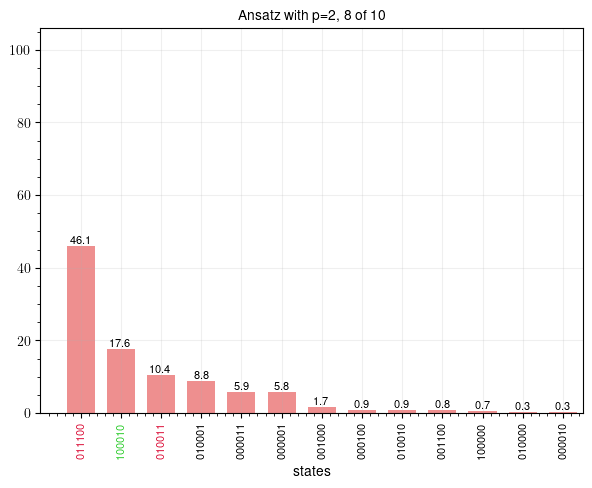

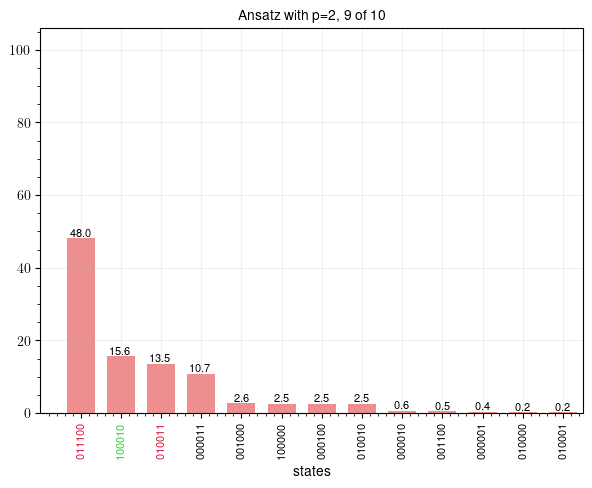

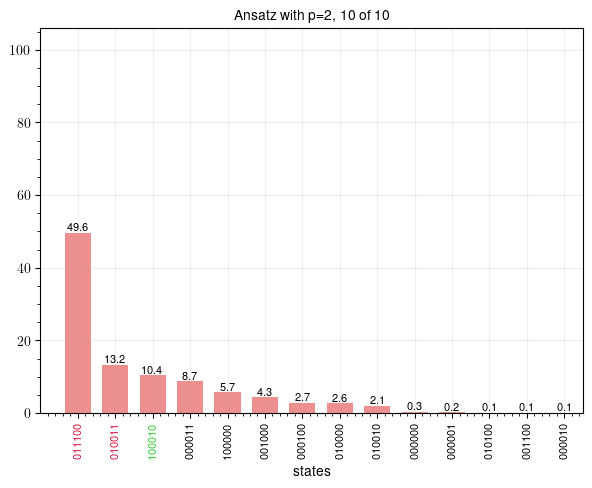

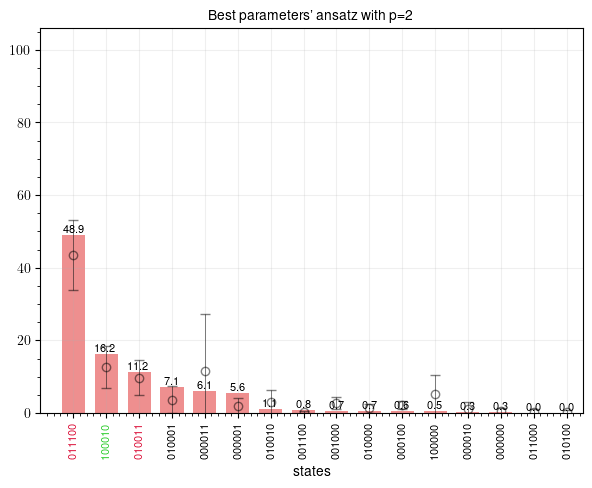


BEST PARAMETERS OFù p=2 LAYER: betas, gammas =  [1.5703824525322005, 0.8291986037730699] [-113.77510257267943, -147.81549993362825]
Execution time of p=2 layer: 2.4 min

 **** p = 3 **** 


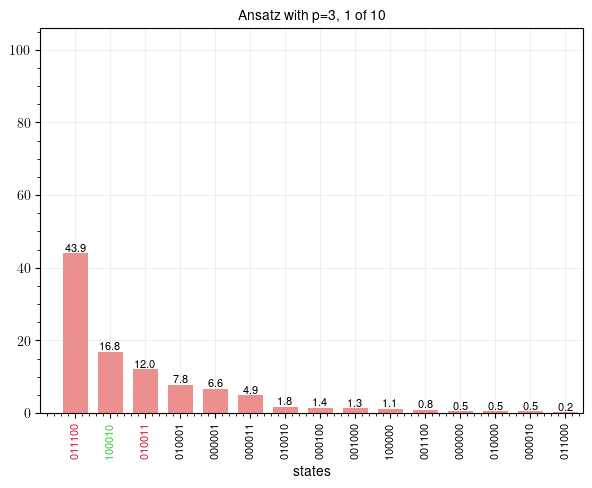

...UPDATING...


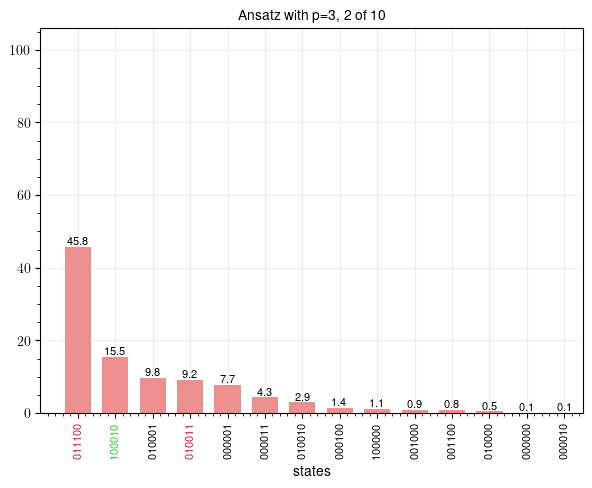

...UPDATING...


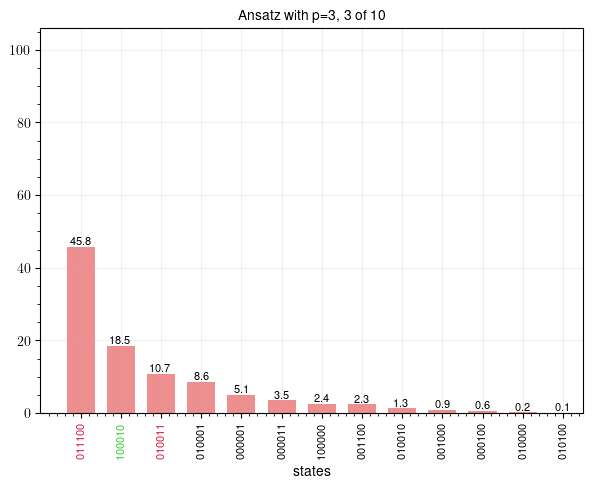

...UPDATING...


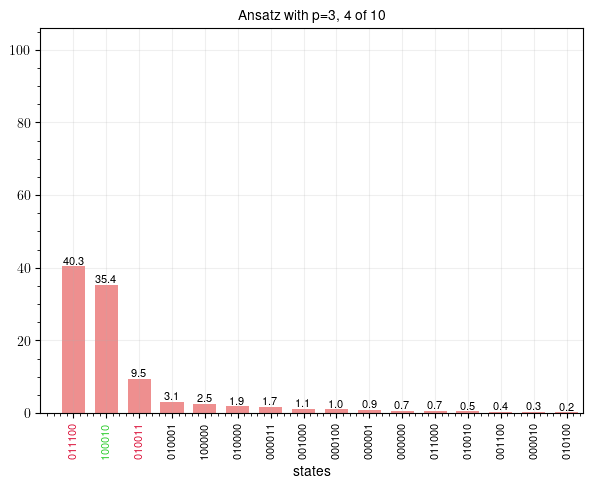

...UPDATING...


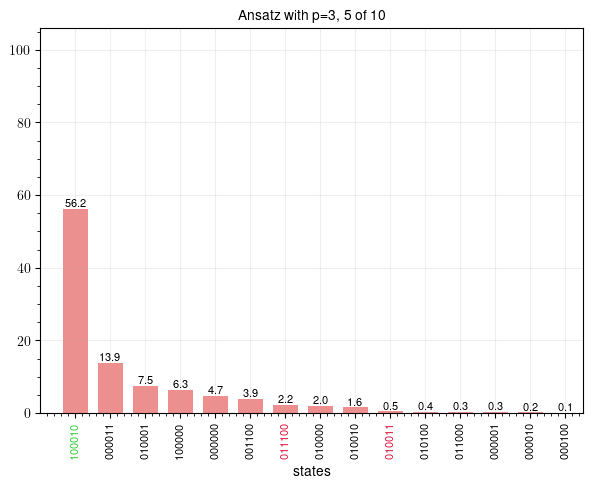

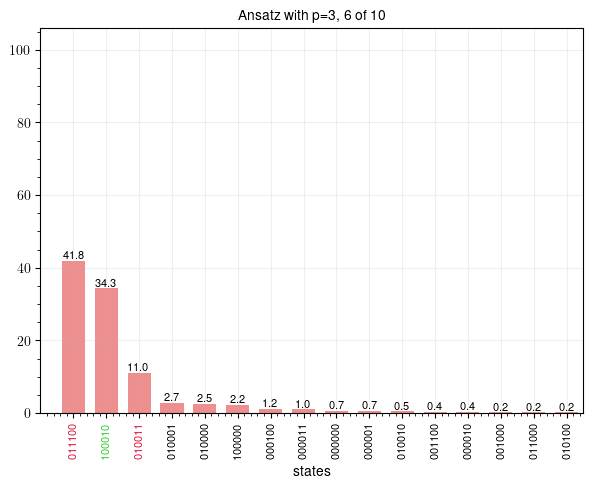

...UPDATING...


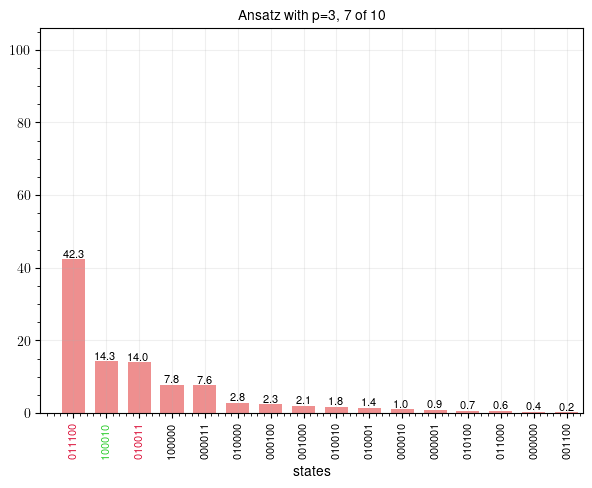

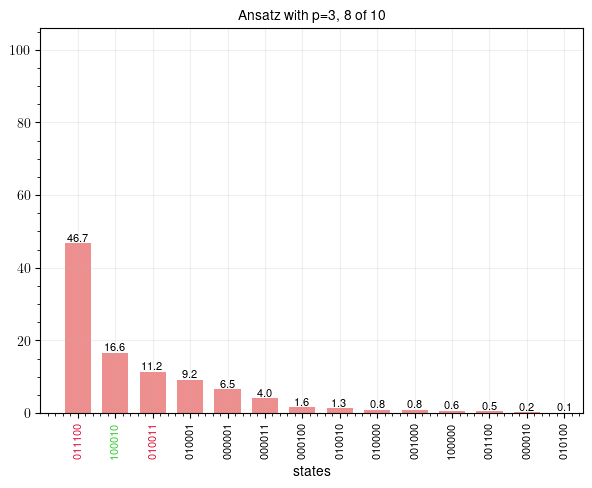

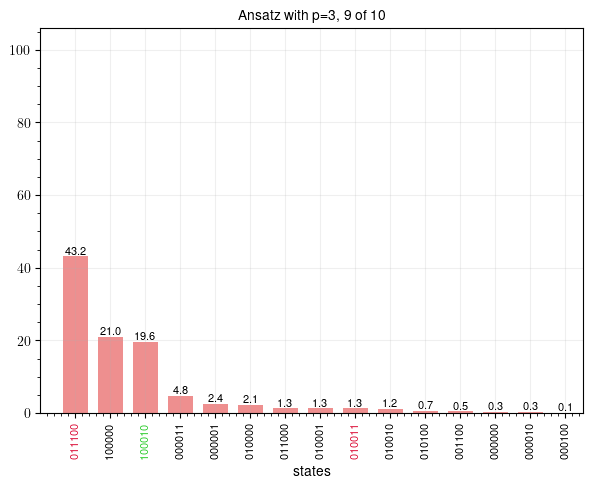

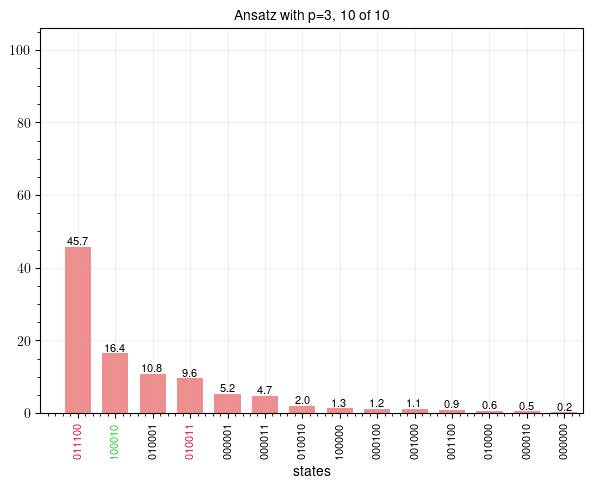

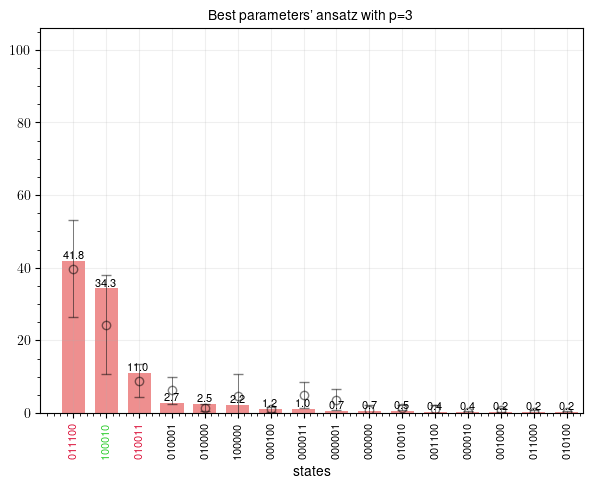


BEST PARAMETERS OFù p=3 LAYER: betas, gammas =  [0.598740708695501, 0.631638033758441, 1.210727676458958] [-115.32174653023068, -136.14868522491747, 138.58727258560694]
Execution time of p=3 layer: 4.8 min

TOTAL ELAPSED TIME: 7.771679079532623 minutes.


<Figure size 640x480 with 0 Axes>

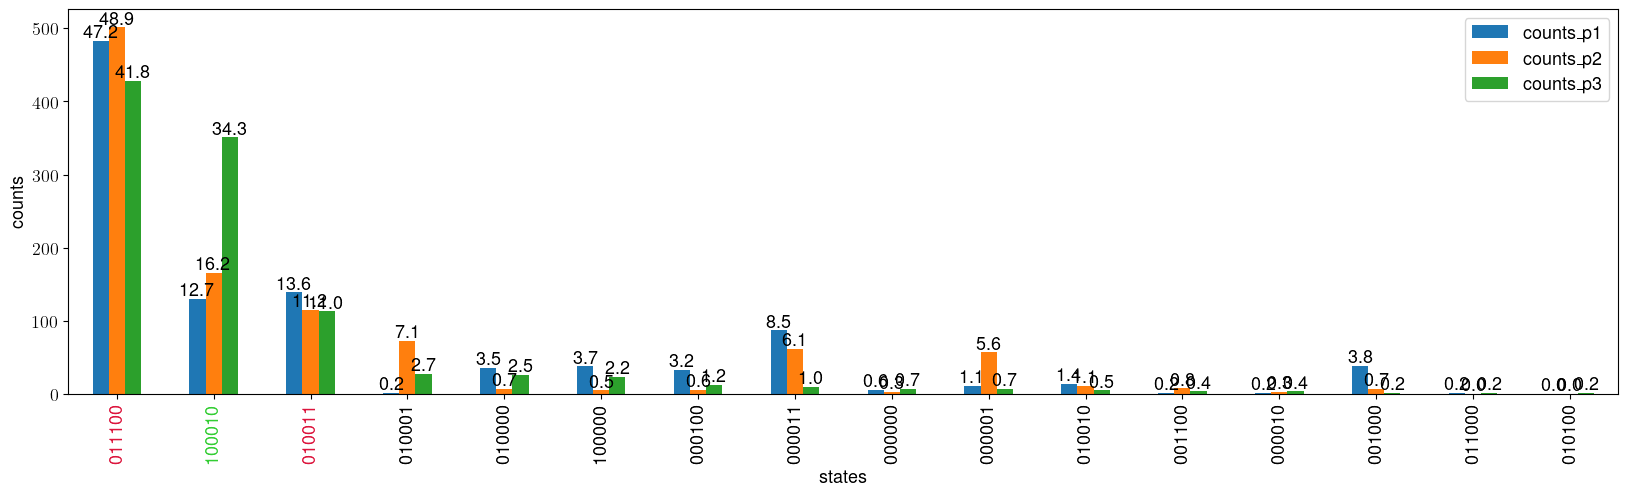

In [11]:
for instance in instances:
    h = h_vector[instance-1]

    ### These will contain the files' names.
    FILENAME_list = [] # list of .csv containing the final histograms data.
    DATA_FILENAME_list = [] # list of .txt containing extra data such as energies, betas, gammas.

    
    ### Define the instance.
    U, subsets_dict = define_instance(n, instance, verbose=False)
    subsets = list(subsets_dict.values())
    _,_, _, _, EXACT_COVERS = find_spectrum(U, subsets_dict, n, h)
    MEC = [state for state in EXACT_COVERS if state.count("1") == min([x.count("1")  for x in EXACT_COVERS])]
    # show_spectrum(n, instance, h)

    
    ### Prepare the cost and mixing circuit.
    constant, hamiltonian, qc_cost = build_cost_circuit(n, instance, h, verbose=False)
    qc_mixing = build_mixing_circuit(n, instance, verbose=False)
    qc_initial = build_initialization_circuit(n, instance, init_name, verbose=False)
    
    ###########################################################
    ###########################################################
    ### SET INITIAL PARAMETERS FOR MINIMIZATION AND BOUNDS
    
    gamma_bound = find_gamma_bound(n, instance, h, verbose=False)
    
    beta_0 = (0, 2*np.pi)
    gamma_0 =  (-gamma_bound, gamma_bound)
    string_0 = f"[0,2pi]x[-{gamma_bound},{gamma_bound}]"
    
    bnds_beta = (0, 2*np.pi)
    bnds_gamma = (-gamma_bound, gamma_bound)
    bnds_string = f"[0,2pi]x[-{gamma_bound},{gamma_bound}]"

    ###########################################################
    ###########################################################
    ### BUILD FILES' NAMES
    
    # current_datetime = datetime.now().strftime("@%Y-%m-%d@%Hh%Mm%Ss")
    current_datetime = datetime.now().strftime("%d-%m")
    
    header = f"kMEC_{current_datetime}_dim{n}_mail{instance}_{init_name}_p{max_p}_{random_attempts}ra_k{h}"
    header = header + f"_BOUNDS{bnds_string}_pars0{string_0}"
    print(header)
    
    DATA_FILENAME = header + '_data.txt'
    DATA_FILENAME_list.append(DATA_FILENAME)

    ###########################################################
    ###########################################################
    ### DO THE MINIMIZATION
    
    with open(DATA_FILENAME, 'a') as DATA_FILE:
        DATA_FILE.write(f"current datetime = {datetime.now().strftime('@%Y-%m-%d@%Hh%Mm%Ss')}")
        DATA_FILE.write(f"The initial state is an equal superposition of: {init_name} \n")
        DATA_FILE.write(f"max_p={max_p}\n")
        DATA_FILE.write(f"Random attempts for each layer: {random_attempts}\n")

        Energies = []
        TOTAL_start_time = time.time()
    
        for p in range(1, max_p+1):
        
            print(f"\n **** p = {p} **** ")
            pth_start_time = time.time()
            E_best = 100
            counter = 0
            Energies_of_layer_p = []
            
            for i in range(1,random_attempts+1):
                print(f"----- {i}/{random_attempts} random_attempts -----", end="\r")
                DATA_FILE.write(f"\n----- {i}/{random_attempts} random_attempts -----\n")
    
                ### Build QAOAAnsatz.
                ansatz = QAOAAnsatz(qc_cost, mixer_operator=qc_mixing, initial_state=qc_initial, reps=p, name='my_QAOA_circuit')
        
                ### Generate a pass manager without providing a backend.
                pm = generate_preset_pass_manager(optimization_level=3)
                ansatz_isa = pm.run(ansatz)
                hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)
            
                estimator = StatevectorEstimator()
                sampler = StatevectorSampler()
            
                
                # *******************************  MINIMIZE  **********************************
                ### Do the minimization.
                if p == 1:
                    pars_0 = [random.uniform(*beta_0)] + [random.uniform(*gamma_0)]  
                else:
                    pars_0 =  pth_betas + [random.uniform(*beta_0)] + pth_gammas + [random.uniform(*gamma_0)]  
                
                bnds = [bnds_beta]*p + [bnds_gamma]*p
                # print(f"pars_0 = {pars_0}")
                # print(f"bnds = {bnds}")
                
                res = minimize(cost_func, pars_0, bounds=bnds,
                               args=(ansatz_isa, hamiltonian_isa, estimator), 
                               method="Nelder-Mead", options={"maxiter": 1000}, tol=1e-4)
                
                ### Select the optimal parameters (betas,gammas) found.
                betas = list(res.x[:p])
                gammas = list(res.x[p:])
                # print(f"Final parameters (after minimization): betas, gammas = {betas}, {gammas}")
    
                ### Minimum cost (energy) reached with minimization.
                E_min = res.fun + constant
                Energies_of_layer_p.append(E_min)
                # E_min = res.fun -A -B  
                # print(f"E_min = res.fun - A - B = {E_min}")
                # print(f"E_min = res.fun + constant = {E_min}")
                
                DATA_FILE.write(f"\nE_min = {E_min}")
                DATA_FILE.write(f'\nE_min\'s parameters: betas = {betas}, gammas = {gammas}\n')             
                
                        
                # ****************************  RUN THE CIRCUIT  ******************************
                ### Assign to the ansatz the 2p parameters found, then run the circuit.
                pars = betas + gammas
                qc = ansatz.assign_parameters(pars)
                qc.measure_all()
                qc_isa = pm.run(qc)
                result = sampler.run([qc_isa], shots=1024).result()
                samp_dist = result[0].data.meas.get_counts()
           
                
                # ****************************  POST PROCESS  **********************************
                # Create a dataframe out of the sampling's results.
                df = pd.DataFrame(samp_dist.items()).rename(columns={0: 'states', 1: 'counts'})
                _, _, NUM_ANC, _ = get_circuit_parameters(subsets, verbose=False)
                df['states'] = df['states'].apply(lambda x: x[NUM_ANC:]) # remove ancillary bits
                df = df.groupby(['states']).sum()
                
                # Create a dictionary with states and occurrences.
                d = df['counts'].to_dict()
                lists = sorted(d.items(), key=lambda item: item[1], reverse=True)
            
                # Invert bit order ("01101 -> 10110")      
                d = invert_counts(d)
            
                # **************************** PLOT THE i-TH DATAFRAME ****************************
                df = pd.DataFrame(d.items())
                df = df.rename(columns={0: 'states', 1: f'counts_p{p}_{i}of{random_attempts}'})    
                df = df.sort_values(f'counts_p{p}_{i}of{random_attempts}', ascending=False) 

                plot_histogram_of_df_column(df, f'counts_p{p}_{i}of{random_attempts}', 
                                            EXACT_COVERS, title=f"Ansatz with p={p}, {i} of {random_attempts}")
                plt.show()

                # Merge dataframes.
                if i == 1:
                    df_p = df
                else:
                    df_p = pd.merge(df_p, df, on="states", how="outer")    
        
                if df['states'].iloc[0] == MEC:    
                    DATA_FILE.write("\n### Most frequent state is MEC ###\n")
                    counter += 1
    
                # ******************* UPDATE PARAMETERS IF ENERGY HAS DECREASED *******************

                if E_min < E_best:
                    print("...UPDATING...")
                    E_best = E_min
                    d_best = d
                    betas_best = betas
                    gammas_best = gammas
                    i_best = i
            # *********************************************************************************
    
            Energies.append(Energies_of_layer_p)
            DATA_FILE.write(f"\n----- p = {p} layer -----\nMinimum energy found in each attempt: ")
            DATA_FILE.write(str(Energies_of_layer_p))
        
            ################### PLOT THE BEST p-TH DATAFRAME ###################
            # Plot the dataframe.
            plot_histogram_of_best_column(df_p, f"counts_p{p}_{i_best}of{random_attempts}",
                                          EXACT_COVERS, title=f"Best parameters' ansatz with p={p}")
            plt.show()

            # ################### SAVE TO CSV AND FIX BETA,GAMMA ###################
            # Save to csv.
            df_best = pd.DataFrame(d_best.items()).rename(columns={0: 'states', 1: f'counts_p{p}'})
            df_best.to_csv(header + f"_p{p}.csv", index=False)
    
            # print(f"E_best = {E_best}")
            DATA_FILE.write(f"\nE_best = {E_best}")
            
            # Best parameters'vector of length 2p found for the p-th cycle
            pth_betas = betas_best
            pth_gammas = gammas_best
            print(f'\nBEST PARAMETERS OFù p={p} LAYER: betas, gammas = ', pth_betas, pth_gammas)
            DATA_FILE.write(f'\nE_best\'s parameters: betas = {pth_betas}, gammas = {pth_gammas}\n')
            
            print("Execution time of p={0} layer: {1:.1f} min".format(p, (time.time() - pth_start_time)/60))
            DATA_FILE.write("Execution time of p={0} layer: {1:.1f} min\n".format(p, (time.time() - pth_start_time)/60))
            # print(f"Most frequent state was MEC / random attempts = {counter} / {random_attempts}") 
            DATA_FILE.write(f"Most frequent state was MEC / random attempts = {counter} / {random_attempts} = {round((counter/random_attempts)*100, 1)}%\n")
        
            # Merge dataframes.
            if p == 1:
                df_final = df_best
            else:
                df_final = pd.merge(df_final, df_best, on="states", how="outer")    
    
        
        # ************************ SEE FINAL RESULT ************************
        # Plot all the dataframes in one picture.
        plt.figure()
        plt.rcParams['font.size'] = 13
        df_final = df_final.fillna(0)
        df_final = df_final.sort_values(f'counts_p{max_p}', ascending=False) 
        df_final.plot(x='states', kind="bar", figsize=(20,5), stacked=False)
        
        # Make labels with percentages.
        ax1 = plt.gca()
        ax1.set_ylabel("counts")
        for i,container in enumerate(ax1.containers):
            p = i+1
            labels = df_final[f'counts_p{p}'].apply(lambda x: (x/df_final[f'counts_p{p}'].sum())*100).round(1).astype('str') + '%'
            ax1.bar_label(container, labels=labels)
        highlight_correct_ticks(plt.gca(), EXACT_COVERS)
        
        
        ######################################################################
        print(f"\nTOTAL ELAPSED TIME: {(time.time() - TOTAL_start_time)/60} minutes.")
        DATA_FILE.write(f"\nTOTAL ELAPSED TIME: {(time.time() - TOTAL_start_time)/60} minutes.\n")

## Read from file

In [53]:
FILENAME_list, DATA_FILENAME_list = find_parameter_fixing_files(path='./', strings=['_p'], verbose=True)

plot_list_of_files_parameter_fixing(FILENAME_list, DATA_FILENAME_list, title='')

./03-10_dim6_mail10_all1_p3_10ra_k0.084_BOUNDS[0,2pi]x[-217,217]_pars0[0,2pi]x[-217,217].csv_p1.csv
./03-10_dim6_mail10_all1_p3_10ra_k0.084_BOUNDS[0,2pi]x[-217,217]_pars0[0,2pi]x[-217,217].csv_p2.csv
./03-10_dim6_mail10_all1_p3_10ra_k0.084_BOUNDS[0,2pi]x[-217,217]_pars0[0,2pi]x[-217,217].csv_p3.csv
./03-10_dim6_mail10_all1_p3_10ra_k0.084_BOUNDS[0,2pi]x[-217,217]_pars0[0,2pi]x[-217,217]_data.txt
./03-10_dim6_mail1_all1_p3_10ra_k0.167_BOUNDS[0,2pi]x[-110,110]_pars0[0,2pi]x[-110,110].csv_p1.csv
./03-10_dim6_mail1_all1_p3_10ra_k0.167_BOUNDS[0,2pi]x[-110,110]_pars0[0,2pi]x[-110,110].csv_p2.csv
./03-10_dim6_mail1_all1_p3_10ra_k0.167_BOUNDS[0,2pi]x[-110,110]_pars0[0,2pi]x[-110,110].csv_p3.csv
./03-10_dim6_mail1_all1_p3_10ra_k0.167_BOUNDS[0,2pi]x[-110,110]_pars0[0,2pi]x[-110,110]_data.txt
./03-10_dim6_mail2_all1_p3_10ra_k0.167_BOUNDS[0,2pi]x[-220,220]_pars0[0,2pi]x[-220,220].csv_p1.csv
./03-10_dim6_mail2_all1_p3_10ra_k0.167_BOUNDS[0,2pi]x[-220,220]_pars0[0,2pi]x[-220,220].csv_p2.csv
./03-10_di

## Altro

In [ ]:
### ENERGIA MINIMA AL VARIARE DI P
"""
Questo è il grafico di quello che su Lee (2021) viene chiamato "mean approximation ratio".
Non credo che però in questo problema abbia senso. L'energia potrebbe diminuire anche nel 
caso in cui finisse in un minimo locale, se il minimo locale ha energia abbastanza bassa.
"""

E_mean = []
E_min = []
E_std = []
E_max = []

for Energies_of_layer_p in Energies:
    e = Energies_of_layer_p
    print(e)
    E_mean.append(np.mean(e))
    E_min.append(np.min(e))
    E_std.append(np.std(e))
    E_max.append(np.max(e))

plt.figure()
plt.grid()
plt.xlabel("p")
plt.ylabel(f"Mean over {random_attempts} mean energies")
p = np.array([str(i+1) for i in np.arange(len(Energies))])
plt.errorbar(x=p, y=E_mean, yerr=E_std, 
             elinewidth=3, capsize=5, barsabove=True, color = 'black', fmt ='o')
plt.plot(p, E_min, color = 'red', linestyle='--', marker="o", label='Minimum values')
plt.plot(p, E_max, color = 'blue', linestyle='--', marker="o", label='Maximum values')

plt.ylim(-1,-0.95)
plt.legend(loc="best")
print("\n E_min = ", E_min)

In [ ]:
# Find the exact cover 
mask = df_final['states'].isin(ECs)
print(df_final.head())
print(mask)

df_exact_covers = df_final[mask]
print(df_exact_covers.head())
exact_covers = df_exact_covers["states"].values
print(exact_covers)
solution =  df_exact_covers["states"].iloc[0]
print(solution)
counts = df_exact_covers.iloc[0, 1:].values
layers = [str(i+1) for i in np.arange(max_p)]

# Plot the figure.
plt.figure()
total = 1024
plt.plot(layers, counts*100/total, linestyle='--', color='k', marker='o', label=f"{solution}")
plt.ylabel("Occurrences [%]")
plt.xlabel("p (number of layers)")
plt.legend()

plt.show()

In [ ]:
probs = []
mask = [] # True if the most frequent state is the correct state, False otherwise

total = 1024

for tup in most_frequent_states:
    state = tup[0]
    count = tup[1]
    if(state in ECs):
        mask.append(True)
    else:
        mask.append(False)
        
    probs.append(100 * count / total)

print(probs, mask)
mask = np.array(mask)
probs = np.array(probs)

# ********************* plot the figure *******************************
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

p = np.arange(1,max_p+1)
plt.errorbar(p[mask], probs[mask], fmt='o', color='g', label='Was the solution')
plt.errorbar(p[~mask], probs[~mask], fmt='o',  color='r', label='Was not the solution')
plt.plot(p, probs, linestyle='--', color='k', alpha = 0.5)

plt.ylabel("Occurrences [%]")
plt.xlabel("p")
plt.legend()
plt.title("Most frequent states")
plt.show()